<a href="https://colab.research.google.com/github/virbickt/do-not-overfit/blob/main/do_not_overfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing dependencies

In [ ]:
!pip install eli5 | grep -v 'Requirement already satisfied'
!pip install -U pyrasgo[df] | grep -v 'Requirement already satisfied'
#!pip install pycaret | grep -v 'Requirement already satisfied'

Requirement already up-to-date: pyrasgo[df] in /usr/local/lib/python3.7/dist-packages (0.2.1)


## Imports

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

simplefilter("ignore", category=ConvergenceWarning)

from sklearn.linear_model import Lasso

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from scipy.stats import skew
from scipy.stats import ks_2samp
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.base import BaseEstimator

import eli5
from eli5.sklearn import PermutationImportance

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from collections import Counter

from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

import pyrasgo
import pycaret.classification as pycr
import pycaret.utils as pycu
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler

from numpy import mean
from numpy import std
from sklearn.feature_selection import RFE

from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.metrics import plot_confusion_matrix

## Helper functions

In [ ]:
def get_score(model: BaseEstimator, x: pd.DataFrame, y: pd.Series) -> float:
    """
    Cross-validates the model over five subsets of the original dataset and outputs an average ROCAUC.
    The score is not logged using MLFlow as the function is only to be used to produce an overview of the performance of
    different models.

    :param model: estimator to be fitted during each of 5 folds. This means that the model is fitted 5 times in total.
    :param x: training vector, where n_samples is the number of samples and n_features is the number of features.
    :param y: target vector relative to x.

    :return: an average of the scores produced during each of 5 fits
    :rtype: float
    """
    scores = cross_val_score(
        model, x, y, cv=5, scoring="roc_auc"
    )
    return scores.mean()

In [ ]:
def get_results(
    model: BaseEstimator,
    x: pd.DataFrame,
    y: pd.Series,
    test_df: pd.DataFrame,
    iteration: int,
) -> pd.DataFrame:
    """
    Trains the model using the latest data and returns the prediction results on the test data saved as csv file.

    :param model: model to be fitted
    :param test_df: test data that has been untouched during the training process
    :param iteration: the number of file to keep track of the files generated thorought

    :return: predictions for each sample in the test set
    :rtype: pd.DataFrame
    """
    model = model
    model.fit(x, y)

    y_pred = model.predict_proba(test_df)[:, 1]

    results = pd.DataFrame({"target": y_pred}).set_index(test_ids)
    results.to_csv(f"results_{iteration}.csv")

    return results

In [ ]:
def get_scoreboard(
    logreg: bool = False,
    gnb: bool = False,
    knn: bool = False,
    svm: bool = False,
    rf: bool = False,
) -> pd.DataFrame:
    """
    Presents the scores stored as global variables before running a function in a form of a dataframe.
    :param bool logreg: whether to include Logistic Regression score into the scoreboard
    :param bool gnb: whether to include Gaussian Naive Bayes score into the scoreboard
    :param bool knn: whether to include K-Nearest Neighbors score into the scoreboard
    :param bool svm: whether to include Support Vector Machine score into the scoreboard
    :param bool rf: whether to include Random Forest Classifier score into the scoreboard
    :return: ROCAUC scores obtained by cross-validation and the scores obtained on Kaggle public scoreboard.
    :rtype: pd.DataFrame
    """
    names = list()

    if logreg:
        names.append("Logistic Regression")

    if gnb:
        names.append("Gaussian Naive Bayes")

    if knn:
        names.append("K-Nearest Neighbors")

    if svm:
        names.append("Support Vector Machine")

    if rf:
        names.append("Random Forrest Classifier")

    scores = list()

    if logreg:
        scores.append(score_logreg)

    if gnb:
        scores.append(score_gnb)

    if knn:
        scores.append(score_knn)

    if svm:
        scores.append(score_svm)

    if rf:
        scores.append(score_rf)

    kag_scores = list()

    if logreg:
        kag_scores.append(logreg_kaggle)

    if gnb:
        kag_scores.append(gnb_kaggle)

    if knn:
        kag_scores.append(knn_kaggle)

    if svm:
        kag_scores.append(svm_kaggle)

    if rf:
        kag_scores.append(rf_kaggle)

    kag_probs = list()

    if logreg:
        kag_probs.append(logreg_kaggle_prob)

    if gnb:
        kag_probs.append(logreg_kaggle_prob)

    if knn:
        kag_probs.append(knn_kaggle_prob)

    if svm:
        kag_probs.append(svm_kaggle_prob)

    if rf:
        kag_probs.append(rf_kaggle_prob)

    results = pd.DataFrame(
        {
            "Model": names,
            "ROCAUC": scores,
            "Kaggle score": kag_scores,
            "Kaggle score (proba)": kag_probs,
        }
    )

    return results

In [ ]:
def get_diff_columns(train_df: pd.DataFrame, test_df: pd.DataFrame, threshold: float = 0.1) -> None:
    """
    Performs the two-sample Kolmogorov-Smirnov test to find variables where distributions differ a lot from each other
    and plots the distributions of those variables.

    :param pd.DataFrame train_df: data to be used for training.
    :param pd.DataFrame test_df: test data, which will eventually be used to obtain predictions.
    :param float threshold: the value against which we judge the difference between two distributions to be statistically significant

    :return: None

    Borrowed from https://www.kaggle.com/yjunwoo14/don-t-overfit-assessment-pvt-0-834-pub-0-844 where the author herself/himself
    has adapted the function taken from https://www.kaggle.com/nanomathias/distribution-of-test-vs-training-data.
    """

    # Find the columns where the distributions are very different
    diff_data = []
    for col in train_df.columns:
        statistic, pvalue = ks_2samp(
            train_df[col].values, 
            test_df[col].values
        )
        if pvalue > 0.05 and np.abs(statistic) < threshold:
            diff_data.append({'feature': col, 'p': np.round(pvalue, 5), 'statistic': np.round(np.abs(statistic), 2)})

    # Put the differences into a dataframe
    diff_df = pd.DataFrame(diff_data).sort_values(by='statistic', ascending=False)
    print(f"number of features with diff distribution : {len(diff_df)}")
    
    n_cols = 5
    n_rows = 5
    _, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))
    axes = [x for l in axes for x in l]

    # Create plots
    for i, (_, row) in enumerate(diff_df.iterrows()):
        if i >= len(axes):
            break
        extreme = np.max(np.abs(train_df[row.feature].tolist() + test_df[row.feature].tolist()))
        train_df.loc[:, row.feature].hist(
            ax=axes[i], alpha=0.5, label='Train', density=True,
            bins=np.arange(-extreme, extreme, 0.25)
        )
        test_df.loc[:, row.feature].hist(
            ax=axes[i], alpha=0.5, label='Test', density=True,
            bins=np.arange(-extreme, extreme, 0.25)
        )
        axes[i].set_title(f"Train mean = {np.round(train_df[row.feature].mean(), 3)}, Test mean = {np.round(test_df[row.feature].mean(), 3)}")
        axes[i].set_xlabel(f'Feature: {row.feature}')
        axes[i].legend()

    plt.tight_layout()
    plt.show()
        
    return None

In [ ]:
def missing_values_pct(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Finds the percentage of missing values for each column.

    :param pd.DataFrame dataset: dataset the columns of which will have the percentage of
    missing values calculated.
    :return: a dataset with features names and percentages of missing values in a descending order.
    :rtype: pd.DataFrame
    """
    percentage = (dataset.isnull().sum() / dataset.isnull().count()).sort_values(
        ascending=False
    )
    total_null = dataset.isnull().sum().sort_values(ascending=False)
    missing_data = [
        total_null.drop(total_null[total_null == 0].index),
        percentage.drop(percentage[percentage == 0].index),
    ]
    missing_data = pd.concat(missing_data, axis=1, keys=["Total", "Percentage"])

    return missing_data

In [ ]:
def backward_selection(df: pd.DataFrame, target: pd.Series, max_features=None) -> pd.DataFrame:
    """
    This function uses the pyrasgo.evaluate.feature_importance and pyrasgo.prune.features functions
    to incrementally remove features from the training set until the RMSE no longer improves.
    This function returns the dataframe with the features that give the best RMSE.

    :param df: the dataframe with features that will be sequentially removed via backward selection.
    :param target: target variable which is going to be used to calculate feature importances. 
    :param max_features: the maximum number of features that the dataframe will contain after pruning.
    :return: the dataframe with a reduced number of features
    :rtype: pd.DataFrame
    """
    # get baseline AUC
    select_df = df.copy()
    total_features = df.shape[1]
    response = rasgo.evaluate.feature_importance(
        select_df, target, return_cli_only=True
    )
    auc = response["modelPerformance"]["AUC"]
    print(f"{auc} with {select_df.shape[1]}")
    last_auc = auc

    # Drop least important feature and recalculate model peformance
    if max_features is None:
        max_features = total_features - 1

    for num_features in range(total_features - 1, 1, -1):
        tmp_df = rasgo.prune.features(select_df, target, top_n=num_features)
        response = rasgo.evaluate.feature_importance(
            tmp_df, target, return_cli_only=True
        )
        auc = response["modelPerformance"]["AUC"]
        print(f"{auc} with {tmp_df.shape[1]}")
        if (num_features < max_features) and (auc > last_auc):
            # AUC increased, return last dataframe
            return select_df
        else:
            # AUC improved, continue dropping features
            last_auc = auc
            select_df = tmp_df
    return select_df

## Uploads

In [ ]:
train_df = pd.read_csv("train.csv")
test_subm = pd.read_csv("test.csv")

train_df = train_df.drop(["id"], axis=1)

test_ids = test_subm["id"]
test_subm = test_subm.drop(["id"], axis=1)

In [ ]:
train_df.head()

,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,-2.246,1.825,-0.912,-0.107,0.305,0.102,0.826,0.417,0.177,-0.673,-0.503,1.864,0.410,-1.927,0.102,-0.931,1.763,1.449,-1.097,-0.686,-0.250,-1.859,1.125,1.009,-2.296,0.385,-0.876,1.528,-0.144,-1.078,-0.403,0.005,1.405,-0.044,-0.458,0.579,2.929,0.833,0.761,0.737,0.669,0.717,-1.542,-1.847,-0.445,1.238,-0.840,-1.891,-1.531,-0.396,-0.927,2.072,0.946,-1.105,0.008,0.933,-1.410,-0.770,1.740,-1.504,-0.391,-1.551,-1.415,-0.974,0.796,-2.464,-1.424,1.230,0.219,0.130,-0.371,-0.930,1.851,1.292,-0.380,1.318,1.146,-0.399,2.227,0.447,0.870,1.420,-1.675,0.019,0.060,0.768,2.563,0.638,1.164,0.407,-1.556,-0.903,1.329,0.452,-0.704,2.218,-1.844,0.158,-1.649,-0.172,-1.167,-1.456,-0.778,0.098,-1.627,0.405,-0.082,-0.797,-0.303,0.710,-0.252,1.920,0.706,-0.915,0.267,-0.607,0.966,-0.337,-2.292,-1.366,-1.085,0.278,0.212,1.260,-1.276,-2.013,-1.101,0.797,0.661,1.232,-0.632,-0.805,1.236,-1.085,-0.067,-0.661,-0.745,1.306,-0.010,-0.475,-0.613,-0.841,-0.837,0.671,2.493,0.689,0.946,0.160,-0.607,-0.775,1.688,0.302,-1.156,-0.718,0.126,0.745,-0.287,-0.565,0.646,-0.119,-0.675,-0.479,-0.191,-0.454,1.314,0.740,0.999,1.242,-0.339,0.403,-1.243,1.365,0.030,-0.475,0.860,0.036,1.313,-0.219,1.078,1.880,-0.317,-0.443,1.876,-0.611,0.892,1.435,-0.226,0.311,0.139,-0.075,1.381,1.716,-2.017,-0.485,1.906,-0.119,0.609,-0.564,0.264,-0.604,-0.733,-2.352,-1.661,0.498,-0.841,0.907,-0.476,0.817,1.372,1.187,0.844,0.028,0.029,-0.808,0.253,1.005,1.413,-0.133,0.655,-0.921,0.231,-1.902,-0.005,-1.730,1.132,-0.194,0.039,1.489,-0.328,0.966,-0.057,-0.181,0.723,-0.313,-0.165,-0.803,0.074,-2.851,-1.021,-0.894,0.967,0.218,-0.692,-0.514,0.754,-1.892,0.203,2.174,-0.755,-1.053,-0.516,-1.109,-0.681,1.250,-0.565,-1.318,-0.923,0.075,-0.704,2.457,0.771,-0.460,0.569,-1.320,-1.516,-2.145,-1.120,0.156,0.820,-1.049,-1.125,0.484,0.617,1.253,1.248,0.504,-0.802,-0.896,-1.793,-0.284,-0.601,0.569,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,0.004,-0.291,2.907,1.085,2.144,1.540,0.584,1.133,1.098,-0.237,-0.498,0.283,-1.100,-0.417,1.382,-0.515,-1.519,0.619,-0.128,0.866,-0.540,1.238,-0.227,0.269,-0.390,-2.721,1.659,0.106,-0.121,1.719,0.411,-0.303,-0.307,0.380,0.503,-1.320,0.339,-1.102,-0.947,0.267,0.695,0.167,0.188,-1.082,-0.872,0.660,0.051,0.303,-0.553,-0.771,0.588,0.472,1.315,-0.467,-0.064,1.808,0.633,1.221,1.112,1.133,-0.543,-2.144,0.151,-0.813,1.966,-1.190,0.190,-0.473,0.002,1.195,-0.799,1.117,-0.759,-0.661,0.406,-0.846,-0.035,-1.634,-0.011,0.503,0.610,-1.822,-0.030,1.188,-0.006,-0.279,1.914,0.620,-1.495,1.787,-0.305,0.602,-1.208,0.893,0.379,1.396,0.581,-0.475,-0.056,-0.691,-0.783,-1.485,1.911,-2.400,-2.372,-0.178,1.550,-0.228,0.674,0.987,1.373,-0.373,0.629,0.229,-0.630,-0.175,0.548,0.074,-2.090,-0.625,-1.131,1.111,-0.100,0.574,-0.660,-1.113,0.802,-0.093,1.302,-0.395,0.745,-0.384,0.066,-0.756,0.495,-0.822,0.13

In [ ]:
test_subm.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,-0.129,-0.687,1.291,0.507,-0.317,1.848,-0.232,-0.340,-0.051,0.804,0.764,1.860,0.262,1.112,-0.491,-1.039,-0.492,0.183,-0.671,-1.313,0.149,0.244,1.072,-1.003,0.832,-1.075,1.988,1.201,-2.065,-0.826,-0.016,0.490,0.191,0.732,1.235,-0.867,-0.616,0.340,0.788,-0.044,0.305,-0.819,-0.447,-1.625,-1.005,-0.653,-0.371,1.556,0.754,-0.688,0.061,0.644,0.645,-0.222,-2.174,-0.610,-1.092,0.917,-1.010,-1.021,-0.179,1.732,-0.366,-1.694,1.038,-0.721,0.112,-0.783,0.940,-1.803,1.295,-1.031,0.452,1.198,-0.206,0.051,-1.055,1.740,-0.910,-0.509,-0.987,-1.011,0.718,0.375,0.101,0.137,-1.585,0.532,-1.201,1.210,-0.374,0.300,-0.110,-0.248,1.464,0.056,-0.038,-0.482,0.585,-1.263,0.993,-0.639,-1.337,0.225,1.640,-1.807,-1.983,-0.638,-0.432,1.890,0.506,1.091,-0.635,1.072,0.262,0.418,-1.294,0.868,0.728,0.618,0.540,1.981,-0.246,0.516,-0.373,0.954,-0.854,-1.241,-0.861,0.317,-0.611,-0.179,-1.658,-1.397,-0.988,-0.316,1.808,0.930,1.098,0.997,0.901,1.095,-0.464,2.592,0.846,1.060,-0.676,0.376,0.047,1.265,1.218,1.003,1.219,-0.624,-1.316,0.921,3.472,-1.123,0.037,0.927,-0.695,-0.046,0.270,0.847,-1.072,0.315,2.522,0.376,-0.015,-1.283,-0.650,-0.106,0.747,0.612,-0.838,0.713,0.048,-1.073,0.657,-0.542,-0.269,-0.482,0.329,0.534,0.337,0.118,-0.164,-0.538,-0.285,1.375,1.194,-0.258,-0.298,1.578,-0.488,1.424,1.106,0.363,-2.007,-0.091,0.551,0.388,0.422,0.099,0.378,-1.333,-1.102,2.145,0.745,0.345,-0.904,0.425,-0.273,0.547,-0.184,0.458,0.182,0.592,0.966,0.540,-1.382,0.069,0.131,-0.068,-0.400,0.413,-0.030,0.890,1.000,-0.774,0.340,2.345,2.748,0.774,-0.355,0.574,0.027,1.437,-0.877,0.532,-0.348,0.926,1.308,-0.120,-1.460,0.755,0.426,1.667,-0.264,1.266,0.962,1.285,1.176,0.824,0.928,1.372,1.505,0.645,0.641,-1.132,1.009,0.998,0.210,-1.634,1.046,0.114,-0.806,0.301,0.145,-0.684,0.794,-0.290,-1.688,0.313,1.140,0.447,-0.616,1.294,0.785,0.453,1.550,-0.866,1.007,-0.088,-2.628,-0.845,2.078,-0.277,2.132,0.609,-0.104,0.312,0.979
1,0.776,0.914,-0.494,1.347,-0.867,0.480,0.578,-0.313,0.203,1.356,-1.086,0.322,0.876,-0.563,-1.394,0.385,1.891,-2.107,-0.636,-0.055,-0.843,0.041,0.253,0.557,0.475,-0.839,-1.146,1.210,1.427,0.347,1.077,-0.194,0.323,0.543,0.894,1.190,0.342,-0.858,0.756,1.350,-0.414,0.748,2.014,0.858,0.025,1.343,0.784,-0.418,-0.515,0.694,-1.097,0.559,-0.799,-0.936,1.483,1.670,1.403,0.457,-1.564,0.049,0.550,-0.085,-0.561,-0.529,-1.563,-0.781,-0.532,0.375,-0.727,-0.053,-0.383,-0.123,1.573,-0.898,-0.070,0.811,-0.036,0.720,1.691,-0.673,-0.421,-1.665,0.099,0.089,2.032,-1.132,-1.827,-0.017,-1.748,-0.717,2.004,1.216,1.547,1.322,0.481,1.819,-0.809,0.617,-0.763,-0.154,-0.847,-0.981,0.274,-1.856,0.808,-0.599,0.998,-0.286,0.649,0.612,-1.002,1.258,0.149,0.252,1.093,-0.344,0.349,-1.386,-0.518,1.478,-1.261,2.206,-0.053,-1.191,-1.118,0.402,0.786,-0.345,-0.387,0.558,2.202,-2.056,1.502,1.191,-0.404,-2.183,1.559,1.077,-0.659,0.339,1.113,0.286,-0.424,-1.061,-0.748,-1.148,1.705,1.239,-0.912,-0.692,-0.274

In [ ]:
print(
    "The train data size (target variable is yet to be dropped): {} ".format(
        train_df.shape
    )
)

print("The test data: {} ".format(test_subm.shape))

The train data size (target variable is yet to be dropped): (250, 301) 
The test data: (19750, 300) 


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Columns: 301 entries, target to 299
dtypes: float64(301)
memory usage: 588.0 KB


In [ ]:
test_subm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19750 entries, 0 to 19749
Columns: 300 entries, 0 to 299
dtypes: float64(300)
memory usage: 45.2 MB


As we can see we have 250 samples in the training set and 197500 samples in the test set, both of which has 300 predictor variables. Moreover, we only have variables of a single data type: float64.

In [ ]:
train_df.describe()

,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.00000,250.00000,250.000000,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.0000

Another thing that has become clear at this point is that our target variable is binary, meaning it only takes values $y_i \in [0, 1]$. We will visualize the distribution of target variable in [$\S$Target](#target)

In [ ]:
test_subm.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
count,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,19750.000000,1975

Final thing that draws our attention just by looking at descriptive statistics table is that the distributions for samples in train set and test set might not be that similar (in contrast to the general assumption for most of the machine learning algorithms). Compare the mean of variable "1": mean value in train set is -0.026872 while in the test set its 0.000972). The difference in means is $\approx$ 27 times larger than the mean value in the test set!

In [ ]:
y = train_df["target"]
X = train_df.drop(["target"], axis=1)

number of features with diff distribution : 284


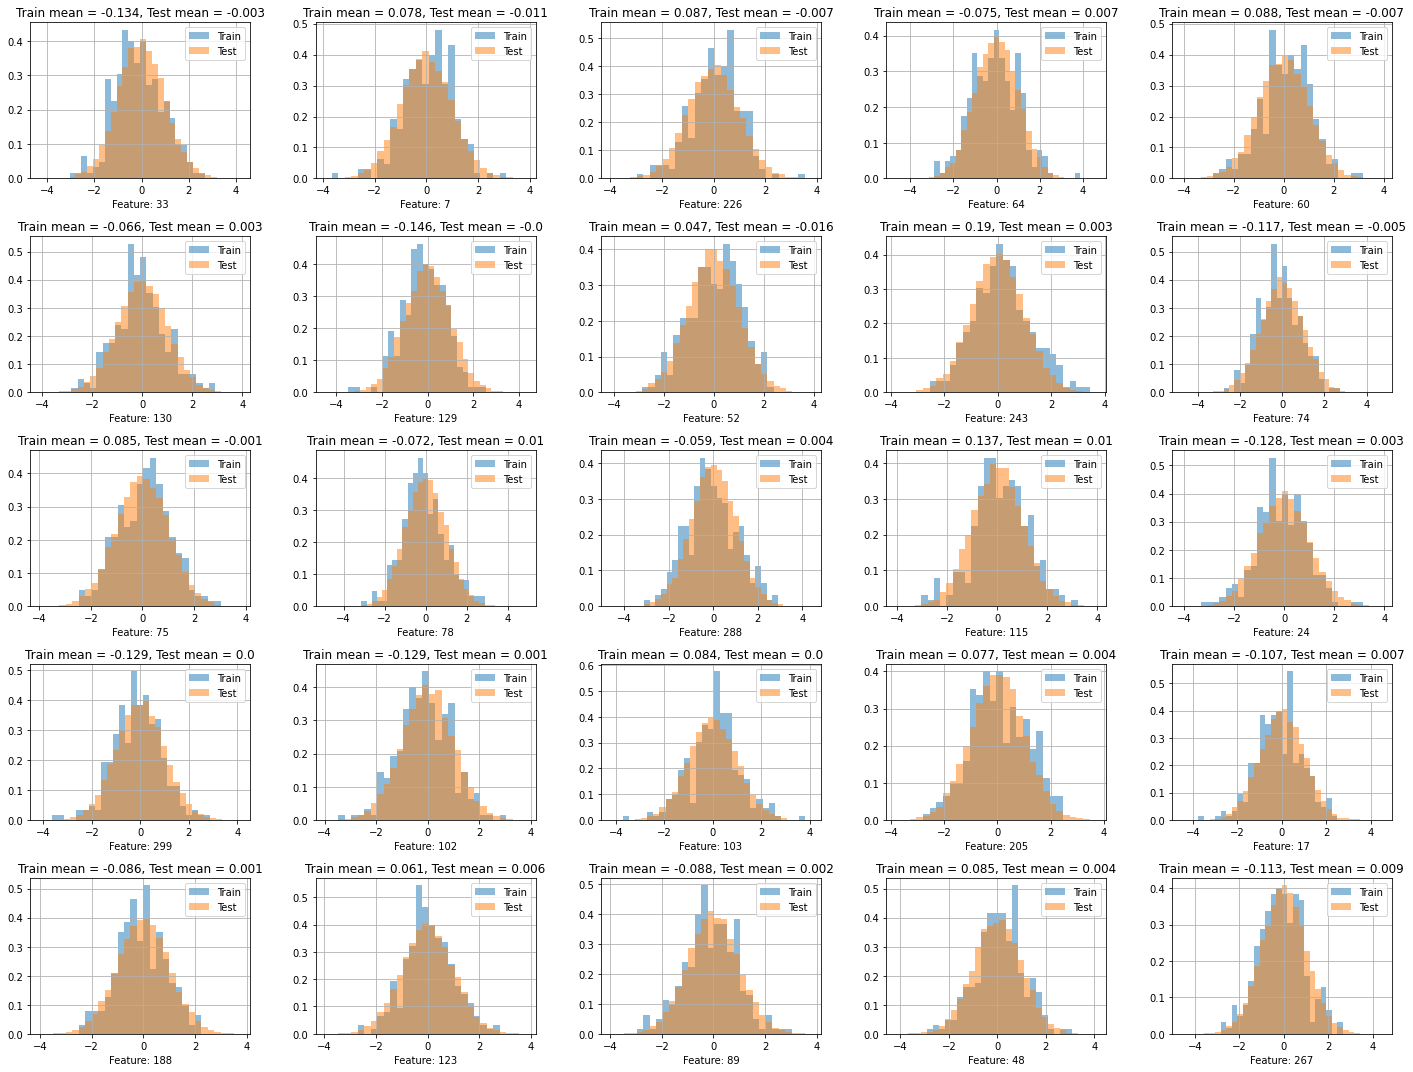

In [ ]:
get_diff_columns(X, test_subm)

Have we chosen a different threshold value to consider a difference between distributions of two variables statistically significant, we would have ended up with a different set of columns. For this reason, we go with a safest option available and standardize both the train and test sets (separately, in order to avoid data leakage) before fitting the models. 

Despite the fact that we identified the variables the distributions of which are significally different (relative to the threshold value), it can stil be the case that there are variables the distributions of which are not different, yet they are not normal whereas normality of the distributions is yet another thing that is usually assumed to have in place before fitting the models. For this we additionally check whether the skewness of the distributions of the variables does not exceed the commonly agreed threshold value of 0.75. 

## Missing values

There is another potential issue looming that could have slipped our attention when looking at the statistics' table, namely, that of missing values. For this task we use a function that should provide us with a number and a percentage of total values that a missing for each of the columns in both train and test sets.

In [ ]:
missing_train = missing_values_pct(train_df)
missing_train.head(10)

,Total,Percentage


In [ ]:
missing_test = missing_values_pct(test_subm)
missing_test.head()

,Total,Percentage


## Outliers

While there no missing values in the form of `NaN`, it could still be the case that there are datapoints lie far from the general distribution of the variable, or, in other words, *an outlier*. For this, we use a series of techniques for automatic outlier detection. 

### Isolation Forest

In [ ]:
iso = IsolationForest(contamination=0.01)
yhat = iso.fit_predict(X)

mask = yhat != -1

In [ ]:
X_out, y_out = X[mask], y[mask]
iso_missno = len(X[~X.isin(X_out)].dropna().index)

In [ ]:
logreg = LogisticRegression()

score_iso = get_score(logreg, X_out, y_out)
print(
    "Our baseline ROCAUC score using Logistic Regression with outliers identified and removed using Isolation Forest: ",
    "{:.4f}".format(score_iso),
)

Our baseline ROCAUC score using Logistic Regression with outliers identified and removed using Isolation Forest:  0.7678


### Elliptic Envelope

In [ ]:
ee = EllipticEnvelope(contamination=0.01)
yhat = ee.fit_predict(X)
mask = yhat != -1

In [ ]:
X_out, y_out = X[mask], y[mask]
ee_missno = len(X[~X.isin(X_out)].dropna().index)

In [ ]:
logreg = LogisticRegression()

score_ee = get_score(logreg, X_out, y_out)
print(
    "Our baseline ROCAUC score using Logistic Regression with outliers identified and removed using Elliptic Envelope: ",
    "{:.4f}".format(score_ee),
)

Our baseline ROCAUC score using Logistic Regression with outliers identified and removed using Elliptic Envelope:  0.7636


### OneClassSVM

In [ ]:
oc = OneClassSVM(nu=0.01)
yhat = oc.fit_predict(X)
mask = yhat != -1

In [ ]:
X_out, y_out = X[mask], y[mask]
oc_missno = len(X[~X.isin(X_out)].dropna().index)

In [ ]:
logreg = LogisticRegression()

score_oc = get_score(logreg, X_out, y_out)
print(
    "Our baseline ROCAUC score using Logistic Regression with outliers identified and removed using OneClassSVM: ",
    "{:.4f}".format(score_oc),
)

Our baseline ROCAUC score using Logistic Regression with outliers identified and removed using OneClassSVM:  0.6917


In [ ]:
techniques = ["Isolation Forest", "EllipticEnvelope", "OneClassSVM"]
scores = [score_iso, score_ee, score_oc]
values_dropped = [iso_missno, ee_missno, oc_missno]

pd.DataFrame(
    {
        "technique": techniques,
        "ROCAUC": scores,
        "Number of rows dropped": values_dropped,
    }
).sort_values(by="ROCAUC", ascending=False)

,technique,ROCAUC,Number of rows dropped
0,Isolation Forest,0.767798,3
1,EllipticEnvelope,0.763564,2
2,OneClassSVM,0.691662,49


As we can see, `EllipticEnvelope` gave the best improvement in score by dropping only 2 rows.

<a name="target"></a>
# Target

Finally we are in a position to look into distribution of the target variable which will show to be quite imbalanced:

In [ ]:
counter = Counter(y)
print(counter)

Counter({1.0: 160, 0.0: 90})


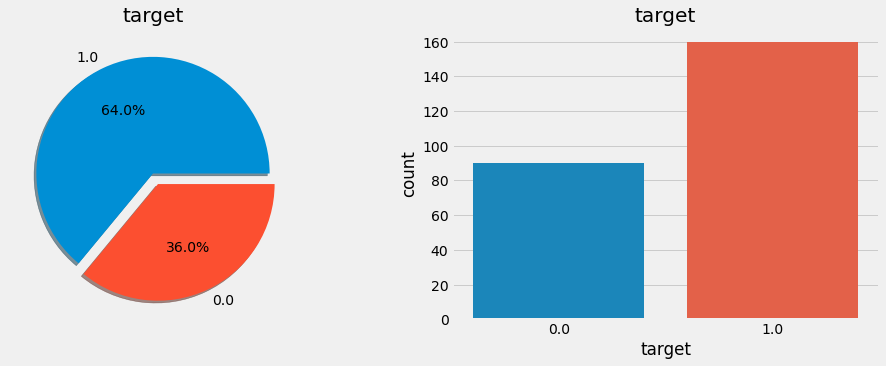

In [ ]:
plt.style.use("fivethirtyeight")
f, ax = plt.subplots(1, 2, figsize=(15, 5))
train_df["target"].value_counts().plot.pie(
    explode=[0, 0.1], autopct="%1.1f%%", ax=ax[0], shadow=True
)
ax[0].set_title("target")
ax[0].set_ylabel("")
sns.countplot("target", data=train_df, ax=ax[1])
ax[1].set_title("target")
plt.show()

In our train set we have 160 samples with a value 1 for the target variable and 90 with a value 0. Once we have our baseline score we will try a range of difference techniques to tackle this issue (commonly referred to as *imbalanced classiication*). 

In [ ]:
corrs = (
    train_df.corr()["target"].sort_values(ascending=False).to_frame().drop(["target"])
)
corrs.query("target > 0.1").sort_values(by="target", ascending=False)

,target
33,0.373608
65,0.293846
24,0.173096
183,0.164146
199,0.159442
201,0.142238
30,0.132705
289,0.127213
114,0.124792
164,0.124151


We can see that features `33` and `65` despite of not being strongly correlated with the target variable (for that the correlation coefficient would have to be > 0.5) are correlated with the target the strongest. We will pay an extra attention to these features in what follows.

# Modeling

## Baseline

### Logistic Regression

In what follows we will start with the simpliest tool (which we will prove to be most effective nonetheless) in our arsenal suited for the type of problem we are facing with: logistic regression. The only motivation for the selection of algorithms to follow (Naive Bayes, K-Nearest Neighbors, Support Vector Machine, Random Forrest Classifier) is that they are all algorithms designed for classification problems. 

However, there is a way to justify the usage of multiple algorithms that differ in complexity: we expect the variety of different models that we will be using to provide support to our initial hypothesis that simplier models will work better in our case (small training set, huge testing set) as the more complex models better adapt to the patterns in the data and tend to overfit as a result.

In [ ]:
logreg = LogisticRegression()

score_logreg = get_score(logreg, X, y)
print(
    "Our baseline ROCAUC score using Logistic Regression is: ",
    "{:.4f}".format(score_logreg),
)

Our baseline ROCAUC score using Logistic Regression is:  0.7590


In [ ]:
from sklearn.metrics import classification_report

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)
logreg.fit(X_train, y_train)
print(
    "Classification report:\n", classification_report(logreg.predict(X_valid), y_valid)
)

Classification report:
               precision    recall  f1-score   support

         0.0       0.45      0.67      0.54        21
         1.0       0.84      0.69      0.76        54

    accuracy                           0.68        75
   macro avg       0.65      0.68      0.65        75
weighted avg       0.73      0.68      0.69        75



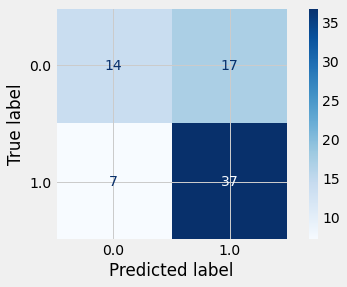

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(logreg, X_valid, y_valid, cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(
    "The baseline ROCAUC score on public leaderbord using Logistic Regression: 0.670",
)

logreg_kaggle = 0.670

The baseline ROCAUC score on public leaderbord using Logistic Regression: 0.670


That the score on Kaggle is worse that the score that cross-validation has resulted in (0.75) is the first indication that even the simpliest of models suitable for the task overfit.

In [ ]:
coefficients = pd.DataFrame({"feature": X.columns, "coef": logreg.coef_[0]}).drop(
    ["feature"], axis=1
)
coefficients.query("coef > 0.2").sort_values(by="coef", ascending=False).nlargest(
    10, "coef"
)

,coef
33,0.672171
65,0.529006
157,0.447347
241,0.427591
199,0.421678
24,0.419680
246,0.363654
244,0.336187
13,0.323108
17,0.311913


We see that features `33` and `65`, the same features that we have found to have the highest correlation with the target, have been assigned the largest coefficients.

In [ ]:
perm = PermutationImportance(logreg, random_state=13).fit(X, y)
eli5.show_weights(perm, top=10, feature_names=train_df.columns[1:].tolist())

Weight,Feature
0.0136 ± 0.0064,217
0.0096 ± 0.0120,33
0.0080 ± 0.0051,119
0.0072 ± 0.0128,65
0.0064 ± 0.0082,111
0.0056 ± 0.0039,17
0.0048 ± 0.0106,91
0.0040 ± 0.0051,244
0.0040 ± 0.0072,98
0.0040 ± 0.0072,180


We find feature `33` on top of the list of feature importances under permutations. The same cannot be said of the remaining features we saw in the list of features that are most correlated with the target and the list of coefficients in the model.

In [ ]:
print(
    "The baseline ROCAUC score on public leaderbord using Logistic Regression (using probabilities): 0.739",
)

logreg_kaggle_prob = 0.739

The baseline ROCAUC score on public leaderbord using Logistic Regression (using probabilities): 0.739


Submitting probabilities, however, resulted in a much higher score on the public leaderboard. We will see whether this behavior repeats itself with other models.

### Naive Bayes

In [ ]:
gnb = GaussianNB()

score_gnb = get_score(gnb, X, y)
print(
    "Our baseline ROCAUC score using Gaussian Naive Bayes is: ",
    "{:.4f}".format(score_gnb),
)

Our baseline ROCAUC score using Gaussian Naive Bayes is:  0.6979


In [ ]:
print(
    "The baseline ROCAUC score on public leaderbord using Gaussian Naive Bayes: 0.611",
)

gnb_kaggle = 0.611

The baseline ROCAUC score on public leaderbord using Gaussian Naive Bayes: 0.611


Submitting probabilities:

In [ ]:
print(
    "The baseline ROCAUC score on public leaderbord using Gaussian Naive Bayes (using probabilities): 0.675",
)

gnb_kaggle_prob = 0.675

The baseline ROCAUC score on public leaderbord using Gaussian Naive Bayes (using probabilities): 0.675


We observe the same behavior in the case of GaussianNB: submitting probabilities results in the higher score than submitting binary values.

### K-Nearest Neighbors

In [ ]:
knn = KNeighborsClassifier()

score_knn = get_score(knn, X, y)
print(
    "Our baseline ROCAUC score using K-Nearest Neighbors is: ",
    "{:.4f}".format(score_knn),
)

Our baseline ROCAUC score using K-Nearest Neighbors is:  0.5627


In [ ]:
print(
    "The baseline ROCAUC score on public leaderbord using K-Nearest Neighbors: 0.549",
)

knn_kaggle = 0.549

The baseline ROCAUC score on public leaderbord using K-Nearest Neighbors: 0.549


In [ ]:
print(
    "The baseline ROCAUC score on public leaderbord using K-Nearest Neighbors: 0.568",
)

knn_kaggle_prob = 0.568

The baseline ROCAUC score on public leaderbord using K-Nearest Neighbors: 0.568


Submitting probabilities predicted by K-Nearest Neighbors gives us the worse improvement over the score with binary values so far.

### Support Vector Machine

In [ ]:
svm = LinearSVC()

score_svm = get_score(svm, X, y)
print(
    "Our baseline ROCAUC score using LinearSVC is: ",
    "{:.4f}".format(score_svm),
)

Our baseline ROCAUC score using LinearSVC is:  0.7441


In [ ]:
print(
    "The baseline ROCAUC score on public leaderbord using LinearSVC: 0.663",
)

svm_kaggle = 0.663

The baseline ROCAUC score on public leaderbord using LinearSVC: 0.663


Submitting probabilities requires us to additionally use `CalibratedClassifierCV`:

In [ ]:
svm = LinearSVC()
clf = CalibratedClassifierCV(svm)
clf.fit(X, y)

y_proba = clf.predict_proba(test_subm)[:, 1]
results = pd.DataFrame({"target": y_proba}).set_index(test_ids)

In [ ]:
print(
    "The baseline ROCAUC score on public leaderbord using LinearSVC: 0.722",
)

svm_kaggle_prob = 0.722

The baseline ROCAUC score on public leaderbord using LinearSVC: 0.722


Submitting probabilities results in a higher score on public leaderboard again.

### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()

score_rf = get_score(rf, X, y)
print(
    "Our baseline ROCAUC score using RandomForestClassifier is: ",
    "{:.4f}".format(score_rf),
)

Our baseline ROCAUC score using RandomForestClassifier is:  0.6642


In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier()

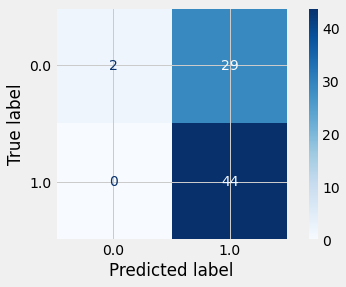

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(rf, X_valid, y_valid, cmap=plt.cm.Blues)
plt.show()

In [ ]:
importances = pd.DataFrame(
    {"feature": X.columns, "feature_importances": rf.feature_importances_}
).drop(["feature"], axis=1)
importances.query("feature_importances > 0.01").sort_values(
    by="feature_importances", ascending=False
).nlargest(10, "feature_importances")

,feature_importances
33,0.026011
91,0.016517
65,0.013105
295,0.011737
24,0.011607
117,0.011554
39,0.010078


Again we observe that features `33` and `65`, the same features that we have found to have the highest correlation with the target, have been found to be most important using Random Forrest Classifier. `PermutationImportance`, however, produce a slighty different top-three:

In [ ]:
perm = PermutationImportance(rf, random_state=13).fit(X, y)
eli5.show_weights(perm, top=10, feature_names=train_df.columns[1:].tolist())

Weight,Feature
0.0072 ± 0.0032,65
0.0072 ± 0.0032,295
0.0064 ± 0.0039,24
0.0056 ± 0.0039,9
0.0056 ± 0.0039,46
0.0056 ± 0.0064,157
0.0056 ± 0.0039,279
0.0056 ± 0.0039,237
0.0048 ± 0.0060,137
0.0048 ± 0.0032,33


In [ ]:
print(
    "The baseline ROCAUC score on public leaderbord using RandomForestClassifier: 0.534",
)

rf_kaggle = 0.534

The baseline ROCAUC score on public leaderbord using RandomForestClassifier: 0.534


In [ ]:
print(
    "The baseline ROCAUC score on public leaderbord using RandomForestClassifier (using probabilities): 0.685",
)

rf_kaggle_prob = 0.685

The baseline ROCAUC score on public leaderbord using RandomForestClassifier (using probabilities): 0.685


Probabilities lead to a higher score in the case of Random Forrest Classifier as well.

### Summary

In [ ]:
get_scoreboard(
    logreg=True, 
    gnb=True,
    knn=True,
    svm=True, 
    rf=True
    ).sort_values(by="Kaggle score", ascending=False)

,Model,ROCAUC,Kaggle score,Kaggle score (proba)
0,Logistic Regression,0.759028,0.670,0.739
3,Support Vector Machine,0.744097,0.663,0.722
1,Gaussian Naive Bayes,0.697917,0.611,0.739
2,K-Nearest Neighbors,0.562674,0.549,0.568
4,Random Forrest Classifier,0.664236,0.534,0.685


 - There is a clear indication of overfitting in model performance
 - The simpler models such as Logistic Regression performs better than the more complex models such as Random Forrest Regressor
 - Submitting probabilities results in a higher score on both private and public leaderboards (only the latter on which is presented in the) on Kaggle
 - The models inspected suffer severely from the disbalance of classes as it is clear from the the number of false positives (zeroes classified as ones in our case).

 It is the last issue that we are going to be addressing in the following series of experiments.

## Iteration 1: optimizing the hyperparameters

### Logistic Regression

In [ ]:
parameters_logreg = {
    "penalty": ["l1", "l2", "elasticnet", "none"],
    "tol": [1e-4, 1e-5],
    "fit_intercept": [True, False],
    "C": [0.6, 0.8, 1.0],
    "class_weight": ["balanced"],
    "solver": ["newton-cg", "lbfgs", "liblinear", "saga"],
    "l1_ratio": [0.6, 0.8, 1.0],
}

gscv_logreg = GridSearchCV(
    logreg, parameters_logreg, n_jobs=-1, scoring="roc_auc", verbose=1, cv=5
)
gscv_logreg.fit(X, y)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 126 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1322 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  1.3min finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.6, 0.8, 1.0], 'class_weight': ['balanced'],
                         'fit_intercept': [True, False],
                         'l1_ratio': [0.6, 0.8, 1.0],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
                         'tol': [0.0001, 1e-05]},
             scoring='roc_auc', verbose=1)

In [ ]:
print((gscv_logreg.best_score_))
gscv_logreg.best_params_

0.8190972222222221


{'C': 0.8,
 'class_weight': 'balanced',
 'fit_intercept': True,
 'l1_ratio': 0.6,
 'penalty': 'l1',
 'solver': 'liblinear',
 'tol': 0.0001}

In [ ]:
logreg_opt = LogisticRegression(
    C=0.8,
    class_weight="balanced",
    fit_intercept=True,
    penalty="l1",
    solver="liblinear",
    tol=0.0001,
)

score_logreg = get_score(logreg_opt, X, y)
print(
    "The ROCAUC score using Logistic Regression (with hyperparameters optimized) is: ",
    "{:.4f}".format(score_logreg),
)

The ROCAUC score using Logistic Regression (with hyperparameters optimized) is:  0.8181


In [ ]:
print(
    "The ROCAUC score on public leaderbord using Logistic Regression (with hyperparameters optimized) is: : 0.738",
)

logreg_kaggle = 0.738

The ROCAUC score on public leaderbord using Logistic Regression (with hyperparameters optimized) is: : 0.738


In [ ]:
print(
    "The ROCAUC score on public leaderbord using Logistic Regression (with hyperparameters optimized) is: : 0.815",
)

logreg_kaggle_prob = 0.815

The ROCAUC score on public leaderbord using Logistic Regression (with hyperparameters optimized) is: : 0.815


### Naive Bayes

In [ ]:
parameters_gnb = {"var_smoothing": [1e-9, 1e-8, 1e-7, 1e-10]}

gscv_gnb = GridSearchCV(
    gnb, parameters_gnb, n_jobs=-1, scoring="roc_auc", verbose=1, cv=5
)
gscv_gnb.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.3s finished


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-10]},
             scoring='roc_auc', verbose=1)

In [ ]:
print((gscv_gnb.best_score_))
gscv_gnb.best_params_

0.6979166666666667


{'var_smoothing': 1e-09}

### KNN

In [ ]:
parameters_knn = {
    "n_neighbors": [5, 10, 15, 30],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"],
    "leaf_size": [10, 20, 30, 40],
    "p": [1, 2, 3],
}

gscv_knn = GridSearchCV(
    knn, parameters_knn, n_jobs=-1, scoring="roc_auc", verbose=1, cv=5
)
gscv_knn.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 1252 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 2436 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  1.4min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [10, 20, 30, 40],
                         'metric': ['euclidean', 'manhattan', 'chebyshev',
                                    'minkowski'],
                         'n_neighbors': [5, 10, 15, 30], 'p': [1, 2, 3]},
             scoring='roc_auc', verbose=1)

In [ ]:
print((gscv_knn.best_score_))
gscv_knn.best_params_

0.6444444444444444


{'algorithm': 'ball_tree',
 'leaf_size': 10,
 'metric': 'minkowski',
 'n_neighbors': 30,
 'p': 3}

In [ ]:
knn_opt = KNeighborsClassifier(
    algorithm="ball_tree", leaf_size=10, metric="minkowski", n_neighbors=30, p=3
)

score_knn = get_score(knn_opt, X, y)
print(
    "The ROCAUC score using KNeighborsClassifier (with hyperparameters optimized) is: ",
    "{:.4f}".format(score_knn),
)

The ROCAUC score using KNeighborsClassifier (with hyperparameters optimized) is:  0.6444


In [ ]:
print(
    "The ROCAUC score on public leaderbord using KNeighborsClassifier (with hyperparameters optimized) is: : 0.541",
)

knn_kaggle = 0.541

The ROCAUC score on public leaderbord using KNeighborsClassifier (with hyperparameters optimized) is: : 0.541


In [ ]:
print(
    "The ROCAUC score on public leaderbord using KNeighborsClassifier (with hyperparameters optimized) is: : 0.635",
)

knn_kaggle_prob = 0.635

The ROCAUC score on public leaderbord using KNeighborsClassifier (with hyperparameters optimized) is: : 0.635


### SVM

In [ ]:
parameters_svm = {
    "penalty": ["l1", "l2"],
    "loss": ["hinge", "squared_hinge"],
    "tol": [1e-3, 1e-4, 1e-5],
    "C": [0.6, 0.8, 1.0],
    "fit_intercept": ["True", False],
    "intercept_scaling": [0.6, 0.8, 1.0],
    "class_weight": ["balanced", None],
}

gscv_svm = GridSearchCV(
    svm, parameters_svm, n_jobs=-1, scoring="roc_auc", verbose=1, cv=5
)
gscv_svm.fit(X, y)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1500 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:   22.1s finished


GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.6, 0.8, 1.0],
                         'class_weight': ['balanced', None],
                         'fit_intercept': ['True', False],
                         'intercept_scaling': [0.6, 0.8, 1.0],
                         'loss': ['hinge', 'squared_hinge'],
                         'penalty': ['l1', 'l2'],
                         'tol': [0.001, 0.0001, 1e-05]},
             scoring='roc_auc', verbose=1)

In [ ]:
print((gscv_svm.best_score_))
gscv_svm.best_params_

0.7444444444444445


{'C': 0.6,
 'class_weight': 'balanced',
 'fit_intercept': 'True',
 'intercept_scaling': 1.0,
 'loss': 'squared_hinge',
 'penalty': 'l2',
 'tol': 0.001}

In [ ]:
svm_opt = LinearSVC(C=0.6, class_weight="balanced", fit_intercept=True)

score_svm = get_score(svm_opt, X, y)
print(
    "The ROCAUC score using LinearSVC (with hyperparameters optimized) is: ",
    "{:.4f}".format(score_svm),
)

The ROCAUC score using LinearSVC (with hyperparameters optimized) is:  0.7444


In [ ]:
svm_opt = LinearSVC(C=0.6, class_weight="balanced", fit_intercept=True)
clf = CalibratedClassifierCV(svm_opt)
clf.fit(X, y)

y_proba = clf.predict_proba(test_subm)[:, 1]
results = pd.DataFrame({"target": y_proba}).set_index(test_ids)
results.to_csv("results_59.csv")

In [ ]:
print(
    "The baseline ROCAUC score on public leaderbord using LinearSVC: 0.722",
)

svm_kaggle_prob = 0.722

The baseline ROCAUC score on public leaderbord using LinearSVC: 0.722


In [ ]:
get_scoreboard(
    logreg=True,
    knn=True,
    svm=True
).sort_values(by="Kaggle score", ascending=False)

,Model,ROCAUC,Kaggle score,Kaggle score (proba)
0,Logistic Regression,0.818056,0.738,0.815
2,Support Vector Machine,0.744444,0.663,0.722
1,K-Nearest Neighbors,0.644444,0.541,0.635


## Iteration 1: oversampling only using SMOTE

In what follows we will be applying SMOTE and its variants which balances the distribution of classes by generating sinthetic instances of the minority class:

In [ ]:
oversample = SMOTE(sampling_strategy="minority")
X_over, y_over = oversample.fit_resample(X, y)

X_train, X_valid, y_train, y_valid = train_test_split(X_over, y_over, test_size=0.3)

counter = Counter(y_over)
print(counter)

Counter({1.0: 160, 0.0: 160})


### Logistic Regression

In [ ]:
logreg = LogisticRegression()

score_logreg = get_score(logreg, X_over, y_over)
print(
    "Our baseline ROCAUC score using Logistic Regression is (after oversampling using SMOTE): ",
    "{:.4f}".format(score_logreg),
)

Our baseline ROCAUC score using Logistic Regression is (after oversampling using SMOTE):  0.9264


Application of SMOTE to balance the distribution of target variables has bolstered the score significantly.

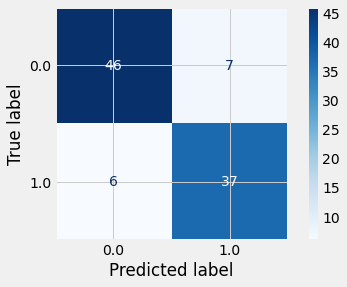

In [ ]:
logreg.fit(X_train, y_train)

plot_confusion_matrix(logreg, X_valid, y_valid, cmap=plt.cm.Blues)
plt.show()

It is clear from the confusion matrix that the false positive rate has been reduced significantly. 

In [ ]:
print(
    "The ROCAUC score on public leaderbord using Logistic Regression after oversampling using SMOTE is: 0.670",
)

logreg_kaggle = 0.670

The ROCAUC score on public leaderbord using Logistic Regression after oversampling using SMOTE is: 0.670


The score on public leaderboard has not improved, however.

In [ ]:
print(
    "The ROCAUC score on public leaderbord using Logistic Regression (using probabilities) is: 0.740",
)

logreg_kaggle_prob = 0.740

The ROCAUC score on public leaderbord using Logistic Regression (using probabilities) is: 0.740


Submission of probabilities produced by the model has not improved significantly (0.01 to be precise).

### Naive Bayes

In [ ]:
gnb = GaussianNB()

score_gnb = get_score(gnb, X_over, y_over)
print(
    "Our baseline ROCAUC score using Gaussian Naive Bayes is: ",
    "{:.4f}".format(score_gnb),
)

Our baseline ROCAUC score using Gaussian Naive Bayes is:  0.8898


In [ ]:
print(
    "The ROCAUC score on public leaderbord using Gaussian Naive Bayes after oversampling is: 0.548",
)

gnb_kaggle = 0.548

The ROCAUC score on public leaderbord using Gaussian Naive Bayes after oversampling is: 0.548


### K-Nearest Neighbors

In [ ]:
knn = KNeighborsClassifier()

score_knn = get_score(knn, X_over, y_over)
print(
    "The ROCAUC score using K-Nearest Neighbors after oversampling is: ",
    "{:.4f}".format(score_knn),
)

The ROCAUC score using K-Nearest Neighbors after oversampling is:  0.5062


In [ ]:
print(
    "The ROCAUC score on public leaderbord using K-Nearest Neighbors after oversampling is: 0.500",
)

knn_kaggle = 0.500

The ROCAUC score on public leaderbord using K-Nearest Neighbors after oversampling is: 0.500


### Support Vector Machine

In [ ]:
svm = LinearSVC()

score_svm = get_score(svm, X_over, y_over)
print(
    "Our baseline ROCAUC score using LinearSVC is: ",
    "{:.4f}".format(score_svm),
)

Our baseline ROCAUC score using LinearSVC is:  0.9154


In [ ]:
print(
    "The ROCAUC score on public leaderbord using LinearSVC after oversampling is: 0.663",
)

svc_kaggle = 0.663

The ROCAUC score on public leaderbord using LinearSVC after oversampling is: 0.663


Submitting probabilities:

In [ ]:
print(
    "The ROCAUC score on public leaderbord using LinearSVC after oversampling is: 0.722",
)

svm_kaggle_prob = 0.722

The ROCAUC score on public leaderbord using LinearSVC after oversampling is: 0.722


### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()

score_rf = get_score(rf, X_over, y_over)
print(
    "The ROCAUC score using RandomForrestClassifier after oversampling is: ",
    "{:.4f}".format(score_rf),
)

The ROCAUC score using RandomForrestClassifier after oversampling is:  0.9071


In [ ]:
print(
    "The ROCAUC score on public leaderbord using RandomForrestClassifier after oversampling is: 0.597",
)

rf_over_kag = 0.597

The ROCAUC score on public leaderbord using RandomForrestClassifier after oversampling is: 0.597


Submitting probabilities:

In [ ]:
print(
    "The ROCAUC score on public leaderbord using Random Forrest Classifier after oversampling is (using probabilities): 0.694",
)

rf_kaggle_prob = 0.694

The ROCAUC score on public leaderbord using Random Forrest Classifier after oversampling is (using probabilities): 0.694


### Summary

In [ ]:
get_scoreboard(
    logreg=True,
    gnb=True,
    knn=True,
    svm=True,
    rf=True
).sort_values(by="Kaggle score", ascending=False)

,Model,ROCAUC,Kaggle score,Kaggle score (proba)
0,Logistic Regression,0.926367,0.670,0.740
3,Support Vector Machine,0.915430,0.663,0.722
1,Gaussian Naive Bayes,0.889844,0.548,0.740
4,Random Forrest Classifier,0.907129,0.534,0.694
2,K-Nearest Neighbors,0.506250,0.500,0.635


 - Application of SMOTE has significantly bolstered RSME score after cross-validation except for KNN, which shows lack of sensitivity to class imbalance. As such, it will not be tested further.
 - The number of negatives classified as positives (false positives) has been reduced significantly
 - The scores on public leaderboard has not been improved though.
 - Submitting probabilities still result in a higher score on Kaggle.
 - Random Forrest Classified has seen the largest jump in the ROCAUC. While insensitive to outliers, it seems to be very sensitive to class imbalance.


## Iteration 2: oversampling using BorderlineSMOTE

In [ ]:
oversample = BorderlineSMOTE(sampling_strategy="minority")
X_over, y_over = oversample.fit_resample(X, y)

X_train, X_valid, y_train, y_valid = train_test_split(X_over, y_over, test_size=0.3)

counter = Counter(y_over)
print(counter)

Counter({1.0: 160, 0.0: 160})


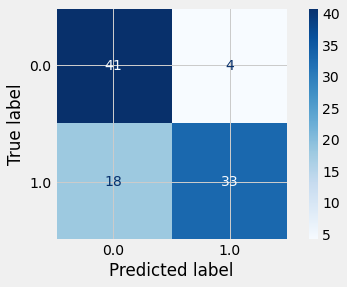

In [ ]:
logreg.fit(X_train, y_train)

plot_confusion_matrix(logreg, X_valid, y_valid, cmap=plt.cm.Blues)
plt.show()

### Logistic Regression

In [ ]:
logreg = LogisticRegression()

score_logreg = get_score(logreg, X_over, y_over)
print(
    "Our baseline ROCAUC score using Logistic Regression after oversampling using BorderlineSMOTE is: ",
    "{:.4f}".format(score_logreg),
)

Our baseline ROCAUC score using Logistic Regression after oversampling using BorderlineSMOTE is:  0.9303


In [ ]:
print(
    "The ROCAUC score on public leaderbord using Logistic Regression after oversampling using BorderlineSMOTE is: 0.675",
)

logreg_kaggle = 0.675

The ROCAUC score on public leaderbord using Logistic Regression after oversampling using BorderlineSMOTE is: 0.675


In [ ]:
print(
    "The ROCAUC score on public leaderbord using Logistic Regression after oversampling using BorderlineSMOTE is: : 0.739",
)

logreg_kaggle_prob = 0.739

The ROCAUC score on public leaderbord using Logistic Regression after oversampling using BorderlineSMOTE is: : 0.739


### Naive Bayes

In [ ]:
gnb = GaussianNB()

score_gnb = get_score(gnb, X_over, y_over)
print(
    "The ROCAUC score using Gaussian Naive Bayes after oversampling using BorderlineSMOTE is: ",
    "{:.4f}".format(score_gnb),
)

The ROCAUC score using Gaussian Naive Bayes after oversampling using BorderlineSMOTE is:  0.8924


In [ ]:
print(
    "The ROCAUC score on public leaderbord using Gaussian Naive Bayes after oversampling using BorderlineSMOTE is: 0.553",
)

gnb_over_kag = 0.553

The ROCAUC score on public leaderbord using Gaussian Naive Bayes after oversampling using BorderlineSMOTE is: 0.553


### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()

score_rf = get_score(rf, X_over, y_over)
print(
    "The ROCAUC score using RandomForrestClassifier after oversampling using BorderlineSMOTE is: ",
    "{:.4f}".format(score_rf),
)

The ROCAUC score using RandomForrestClassifier after oversampling using BorderlineSMOTE is:  0.8889


In [ ]:
print(
    "The ROCAUC score on public leaderbord using RandomForrestClassifier after oversampling is: 0.597",
)

rf_over_kag = 0.597

The ROCAUC score on public leaderbord using RandomForrestClassifier after oversampling is: 0.597


Submitting probabilities:

In [ ]:
print(
    "The ROCAUC score on public leaderbord using Random Forrest Classifier after oversampling using BorderlineSMOTE is (using probabilities): 0.694",
)

rf_kaggle_prob = 0.694

The ROCAUC score on public leaderbord using Random Forrest Classifier after oversampling using BorderlineSMOTE is (using probabilities): 0.694


### Summary

In [ ]:
get_scoreboard(logreg=True, gnb=True, rf=True)

,Model,ROCAUC,Kaggle score,Kaggle score (proba)
0,Logistic Regression,0.930273,0.675,0.739
1,Gaussian Naive Bayes,0.892383,0.548,0.739
2,Random Forrest Classifier,0.888867,0.534,0.694


- Applying BorderlineSMOTE gave us even higher ROCAUC for cross-validation yet no improvement in scores on Kaggle leaderboard (neither by submitting binary values nor probabilities)

## Iteration 3: oversampling using SVMSMOTE

Another technique we will use to address the class inbalance in the data is SVMSMOTE. It differs from base SMOTE in that it uses SVM to find and generate the most simple datapoints to bring the numbers of the minority class

In [ ]:
oversample = SVMSMOTE(sampling_strategy="minority")
X_over, y_over = oversample.fit_resample(X, y)

X_train, X_valid, y_train, y_valid = train_test_split(X_over, y_over, test_size=0.3)

counter = Counter(y_over)
print(counter)

Counter({1.0: 160, 0.0: 160})


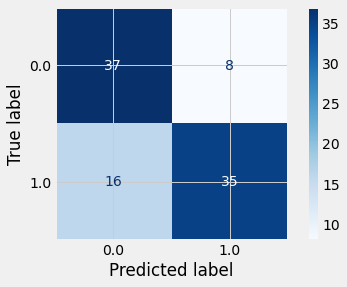

In [ ]:
logreg.fit(X_train, y_train)

plot_confusion_matrix(logreg, X_valid, y_valid, cmap=plt.cm.Blues)
plt.show()

### Logistic Regression

In [ ]:
logreg = LogisticRegression()

score_logreg = get_score(logreg, X_over, y_over)
print(
    "Our baseline ROCAUC score using Logistic Regression after oversampling using SVMSMOTE is: ",
    "{:.4f}".format(score_logreg),
)

Our baseline ROCAUC score using Logistic Regression after oversampling using SVMSMOTE is:  0.9082


In [ ]:
print(
    "The ROCAUC score on public leaderbord using Logistic Regression after oversampling using SVMSMOTE is: 0.677",
)

logreg_over_kag = 0.677

The ROCAUC score on public leaderbord using Logistic Regression after oversampling using SVMSMOTE is: 0.677


In [ ]:
print(
    "The ROCAUC score on public leaderbord using Logistic Regression after oversampling using SVMSMOTE is: : 0.739",
)

logreg_kaggle_prob = 0.739

The ROCAUC score on public leaderbord using Logistic Regression after oversampling using SVMSMOTE is: : 0.739


### Naive Bayes

In [ ]:
gnb = GaussianNB()

score_gnb = get_score(gnb, X_over, y_over)
print(
    "Our baseline ROCAUC score using Gaussian Naive Bayes after oversampling using SVMSMOTE is: ",
    "{:.4f}".format(score_gnb),
)

Our baseline ROCAUC score using Gaussian Naive Bayes after oversampling using SVMSMOTE is:  0.7363


In [ ]:
print(
    "The ROCAUC score on public leaderbord using Gaussian Naive Bayes after oversampling using SVMSMOTE is: 0.577",
)

gnb_over_kag = 0.577

The ROCAUC score on public leaderbord using Gaussian Naive Bayes after oversampling using SVMSMOTE is: 0.577


### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()

score_rf = get_score(rf, X_over, y_over)
print(
    "The ROCAUC score using RandomForestClassifier after oversampling using SVMSMOTE is: ",
    "{:.4f}".format(score_rf),
)

The ROCAUC score using RandomForestClassifier after oversampling using SVMSMOTE is:  0.8820


In [ ]:
print(
    "The ROCAUC score on public leaderbord using RandomForestClassifier after oversampling using SVMSMOTE is: 0.597",
)

rf_over_kag = 0.597

The ROCAUC score on public leaderbord using RandomForestClassifier after oversampling using SVMSMOTE is: 0.597


Submitting probabilities:

In [ ]:
print(
    "The ROCAUC score on public leaderbord using RandomForestClassifier after oversampling using SVMSMOTE is (using probabilities): 0.694"
)

rf_kaggle_prob = 0.694

The ROCAUC score on public leaderbord using RandomForestClassifier after oversampling using SVMSMOTE is (using probabilities): 0.694


### Summary

In [ ]:
get_scoreboard(logreg=True, gnb=True, rf=True)

,Model,ROCAUC,Kaggle score,Kaggle score (proba)
0,Logistic Regression,0.908203,0.675,0.739
1,Gaussian Naive Bayes,0.736328,0.548,0.739
2,Random Forrest Classifier,0.882031,0.534,0.694


- Applying SVMSMOTE resulted in a sligtly lower score for Logistic Regression, yet in a higher score for Random Forrest Classifier. Scores on public leaderboard have not been effected.

## Iteration 4: oversampling using ADASYN



Final technique that we will used is ADASYN.

In [ ]:
oversample = ADASYN()
X_over, y_over = oversample.fit_resample(X, y)

X_train, X_valid, y_train, y_valid = train_test_split(X_over, y_over, test_size=0.3)

counter = Counter(y_over)
print(counter)

Counter({0.0: 175, 1.0: 160})


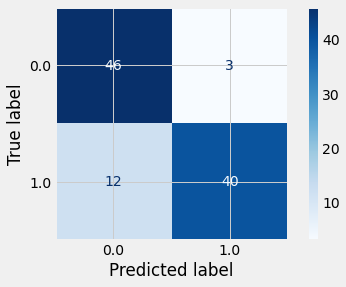

In [ ]:
logreg.fit(X_train, y_train)

plot_confusion_matrix(logreg, X_valid, y_valid, cmap=plt.cm.Blues)
plt.show()

We see that ADESYN has balanced out the number of false positives and false negatives.

### Logistic Regression

In [ ]:
logreg = LogisticRegression()

score_logreg = get_score(logreg, X_over, y_over)
print(
    "The ROCAUC score using Logistic Regression after oversampling using ADESYN is: ",
    "{:.4f}".format(score_logreg),
)

The ROCAUC score using Logistic Regression after oversampling using ADESYN is:  0.9525


In [ ]:
print(
    "The ROCAUC score on public leaderbord using Logistic Regression after oversampling using ADESYN is: 0.672"
)

logreg_over_kag = 0.672

The ROCAUC score on public leaderbord using Logistic Regression after oversampling using ADESYN is: 0.672


In [ ]:
print(
    "The ROCAUC score on public leaderbord using Logistic Regression after oversampling using ADESYN is: 0.739"
)

logreg_kaggle_prob = 0.739

The ROCAUC score on public leaderbord using Logistic Regression after oversampling using ADESYN is: 0.739


### Naive Bayes

In [ ]:
gnb = GaussianNB()

score_gnb = get_score(gnb, X_over, y_over)
print(
    "Our baseline ROCAUC score using Gaussian Naive Bayes after oversampling using ADESYN is: ",
    "{:.4f}".format(score_gnb),
)

Our baseline ROCAUC score using Gaussian Naive Bayes after oversampling using ADESYN is:  0.9079


In [ ]:
print(
    "The ROCAUC score on public leaderbord using Gaussian Naive Bayes after oversampling using ADESYN is: 0.577",
)

gnb_over_kag = 0.577

The ROCAUC score on public leaderbord using Gaussian Naive Bayes after oversampling using ADESYN is: 0.577


### Support Vector Machine

In [ ]:
svm = LinearSVC()

score_svm = get_score(svm, X_over, y_over)
print(
    "The ROCAUC score using Support Vector Machine after oversampling using ADESYN is: ",
    "{:.4f}".format(score_svm),
)

The ROCAUC score using Support Vector Machine after oversampling using ADESYN is:  0.9309


In [ ]:
print(
    "The ROCAUC score on public leaderbord using Suport Vector Machine  after oversampling using ADESYN is: 0.663",
)

svm_over_kag = 0.663

The ROCAUC score on public leaderbord using Suport Vector Machine  after oversampling using ADESYN is: 0.663


In [ ]:
print(
    "The ROCAUC score on public leaderbord using LinearSVC after oversampling using ADESYN: 0.722",
)

svm_kaggle_prob = 0.722

The ROCAUC score on public leaderbord using LinearSVC after oversampling using ADESYN: 0.722


### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()

score_rf = get_score(rf, X_over, y_over)
print(
    "The ROCAUC score using RandomForrestClassifier after oversampling using ADESYN is: ",
    "{:.4f}".format(score_rf),
)

The ROCAUC score using RandomForrestClassifier after oversampling using ADESYN is:  0.9416


In [ ]:
print(
    "The ROCAUC score on public leaderbord using RandomForrestClassifier after oversampling using ADESYN is: 0.613",
)

rf_over_kag = 0.613

The ROCAUC score on public leaderbord using RandomForrestClassifier after oversampling using ADESYN is: 0.613


In [ ]:
print(
    "The ROCAUC score on public leaderbord using Random Forrest Classifier after oversampling using SVMSMOTE is (using probabilities): 0.687",
)

rf_kaggle_prob = 0.687

The ROCAUC score on public leaderbord using Random Forrest Classifier after oversampling using SVMSMOTE is (using probabilities): 0.687


### Summary

In [ ]:
get_scoreboard(logreg=True, gnb=True, svm=True, rf=True)

,Model,ROCAUC,Kaggle score,Kaggle score (proba)
0,Logistic Regression,0.952500,0.675,0.739
1,Gaussian Naive Bayes,0.907857,0.548,0.739
2,Support Vector Machine,0.930893,0.663,0.722
3,Random Forrest Classifier,0.941607,0.534,0.687


- Applying ADESYN bolstered ROCAUC cross-validation scores for all the models significantly, yet it hasn't helped to achieve an improvement to the score on public scoreboards.

## Iteration 5: pruning features

In what follows we will be conducting experiments to test what effect does lowering the number of features have on the our score. This will be done using [Rasgo](https://www.rasgoml.com/), a free python package that helps accelerating feature engineering by delivering actionable, time-saving data visualizations and feature analysis in a web-based user interface.

### First experiment

In [ ]:
rasgo.activate_experiment('First Tutorial Experiment')

Activated existing experiment with name First Tutorial Experiment for dataframe: i0RWdhvWWeo-mOJ8G-SxjK4B-ihEiw5QagOiReehvGU


In [ ]:
response = rasgo.evaluate.profile(train_df)

Profile URL: https://app.rasgoml.com/dataframes/keeUAzNTHA4m_pN0o6PidXp7oN-rRCTGMMnkoPKUeuc/features


In [ ]:
target = 'target'
response = rasgo.evaluate.feature_importance(train_df, target_column=target)

Calculating Feature Importance:  62%|██████▎   | 5/8 [00:10<00:09,  3.29s/step]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Importance URL: https://app.rasgoml.com/dataframes/keeUAzNTHA4m_pN0o6PidXp7oN-rRCTGMMnkoPKUeuc/importance


In [ ]:
response['modelPerformance']['AUC']

0.8026315789473685

In [ ]:
df = rasgo.prune.features(train_df, target_column=target, top_n_pct=.5)

Prune Method: Keeping top 0.5 of features
Calculating Feature Importance:  62%|██████▎   | 5/8 [00:11<00:10,  3.62s/step]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Importance URL: https://app.rasgoml.com/dataframes/i0RWdhvWWeo-mOJ8G-SxjK4B-ihEiw5QagOiReehvGU/importance
Dropped features not in top 0.5 pct: ['201', '123', '84', '292', '282', '85', '195', '248', '191', '142', '138', '284', '246', '241', '167', '131', '93', '259', '247', '29', '240', '198', '249', '161', '58', '43', '272', '137', '10', '61', '220', '178', '180', '18', '171', '88', '87', '56', '143', '81', '112', '20', '270', '197', '5', '188', '54', '281', '111', '211', '11', '75', '76', '121', '278', '215', '77', '94', '145', '202', '155', '22', '187', '273', '263', '296', '136', '98', '286', '139', '67', '277', '38', '17', '95', '196', '103', '109', '126', '110', '113', '294', '225', '128', '47', '49', '159', '14', '205', '66', '250', '21', '8', '40', '186', '251', '212', '28', '206', '216', '51', '185', '274', '35', '283', '7', '37', '153', '50', '207', '218', '158', '74', '271', '175', '291', '166', '146', '223', '299', '260', '257', '6', '122', '267', '36', '97', '190', '96', '5

In [ ]:
response = rasgo.evaluate.feature_importance(df, target_column=target)
response['modelPerformance']['AUC']

Calculating Feature Importance:  62%|██████▎   | 5/8 [00:09<00:08,  2.91s/step]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Importance URL: https://app.rasgoml.com/dataframes/i0RWdhvWWeo-mOJ8G-SxjK4B-ihEiw5QagOiReehvGU/importance


0.8405103668261563

Keeping only a half of the features improved by score by 0.04. Let us removea further quarter of the remaining half of the features:

In [ ]:
df = rasgo.prune.features(df, target_column=target, top_n_pct=.75)

Prune Method: Keeping top 0.75 of features
Calculating Feature Importance:  62%|██████▎   | 5/8 [00:09<00:08,  2.95s/step]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Importance URL: https://app.rasgoml.com/dataframes/i0RWdhvWWeo-mOJ8G-SxjK4B-ihEiw5QagOiReehvGU/importance
Dropped features not in top 0.75 pct: ['129', '118', '264', '254', '71', '174', '140', '182', '163', '79', '269', '221', '1', '52', '224', '233', '256', '204', '193', '26', '3', '200', '13', '144', '172', '124', '41', '149', '234', '261', '242', '57', '23', '170', '290', '125', '2', '177']


In [ ]:
response = rasgo.evaluate.feature_importance(df, target_column=target)
response['modelPerformance']['AUC']

Calculating Feature Importance:  62%|██████▎   | 5/8 [00:08<00:07,  2.61s/step]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Importance URL: https://app.rasgoml.com/dataframes/i0RWdhvWWeo-mOJ8G-SxjK4B-ihEiw5QagOiReehvGU/importance


0.7159090909090909

It seems that once the reduced number of features (112) become smaller than a half of the total number of features (150), ROC starts decreasing. 

In [ ]:
rasgo.end_experiment()

Experiment ended


### Second experiment 

We finished last experiment by having our ROC to drop significantly once we dropped more than half the total number of features. However, we've made huge jumps as we switched from having 150 to only 112 features. When we're still with a half of features, how do we know how many more features do we have to drop to have our ROC improve further before it starts decreasing? 

This is exactly the goal of the present experiment. Once we're with half the features again, we will keep 99% of the remaining features ordered according to their importance.

In [ ]:
rasgo.activate_experiment('Second Experiment')

Activated new experiment with name Second Experiment for dataframe: 4XRCUsFsLBJ_of-meWSZanwgZJg_OVL32tI97e9va_A


In [ ]:
response = rasgo.evaluate.profile(train_df)

Profile URL: https://app.rasgoml.com/dataframes/4XRCUsFsLBJ_of-meWSZanwgZJg_OVL32tI97e9va_A/features


In [ ]:
response = rasgo.evaluate.feature_importance(train_df, target_column=target)

Calculating Feature Importance:  62%|██████▎   | 5/8 [00:09<00:09,  3.11s/step]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Importance URL: https://app.rasgoml.com/dataframes/4XRCUsFsLBJ_of-meWSZanwgZJg_OVL32tI97e9va_A/importance


In [ ]:
response['modelPerformance']['AUC']

0.7841880341880342

In [ ]:
df = rasgo.prune.features(train_df, target_column=target, top_n_pct=.5)

Prune Method: Keeping top 0.5 of features
Calculating Feature Importance:  62%|██████▎   | 5/8 [00:10<00:09,  3.28s/step]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Importance URL: https://app.rasgoml.com/dataframes/4XRCUsFsLBJ_of-meWSZanwgZJg_OVL32tI97e9va_A/importance
Dropped features not in top 0.5 pct: ['222', '223', '224', '225', '286', '285', '229', '230', '232', '243', '172', '284', '235', '236', '237', '238', '283', '239', '240', '241', '242', '220', '150', '170', '59', '45', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '60', '43', '64', '66', '67', '68', '69', '71', '72', '73', '74', '75', '76', '77', '78', '44', '42', '81', '21', '2', '3', '6', '7', '8', '9', '10', '11', '12', '14', '15', '17', '19', '23', '41', '24', '25', '28', '29', '30', '31', '32', '34', '35', '36', '37', '38', '40', '80', '82', '169', '144', '127', '128', '129', '130', '132', '133', '135', '136', '137', '138', '139', '140', '143', '145', '123', '146', '149', '1', '151', '153', '154', '155', '157', '159', '160', '161', '162', '163', '124', '122', '83', '101', '84', '85', '87', '88', '89', '92', '93', '94', '96', '97', '98', '99', '100', '1

In [ ]:
response = rasgo.evaluate.feature_importance(df, target_column=target)
response['modelPerformance']['AUC']

Calculating Feature Importance:  62%|██████▎   | 5/8 [00:08<00:07,  2.58s/step]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Importance URL: https://app.rasgoml.com/dataframes/4XRCUsFsLBJ_of-meWSZanwgZJg_OVL32tI97e9va_A/importance


0.7593582887700535

Due to stochastic nature of the default model that is used to produce feature importances and remove features accordingly, we end up with different sets of features that have been removed from the dataset. We will be addressing this issue shortly.

In [ ]:
set1 = set(
    [
        "201",
        "123",
        "84",
        "292",
        "282",
        "85",
        "195",
        "248",
        "191",
        "142",
        "138",
        "284",
        "246",
        "241",
        "167",
        "131",
        "93",
        "259",
        "247",
        "29",
        "240",
        "198",
        "249",
        "161",
        "58",
        "43",
        "272",
        "137",
        "10",
        "61",
        "220",
        "178",
        "180",
        "18",
        "171",
        "88",
        "87",
        "56",
        "143",
        "81",
        "112",
        "20",
        "270",
        "197",
        "5",
        "188",
        "54",
        "281",
        "111",
        "211",
        "11",
        "75",
        "76",
        "121",
        "278",
        "215",
        "77",
        "94",
        "145",
        "202",
        "155",
        "22",
        "187",
        "273",
        "263",
        "296",
        "136",
        "98",
        "286",
        "139",
        "67",
        "277",
        "38",
        "17",
        "95",
        "196",
        "103",
        "109",
        "126",
        "110",
        "113",
        "294",
        "225",
        "128",
        "47",
        "49",
        "159",
        "14",
        "205",
        "66",
        "250",
        "21",
        "8",
        "40",
        "186",
        "251",
        "212",
        "28",
        "206",
        "216",
        "51",
        "185",
        "274",
        "35",
        "283",
        "7",
        "37",
        "153",
        "50",
        "207",
        "218",
        "158",
        "74",
        "271",
        "175",
        "291",
        "166",
        "146",
        "223",
        "299",
        "260",
        "257",
        "6",
        "122",
        "267",
        "36",
        "97",
        "190",
        "96",
        "55",
        "19",
        "44",
        "245",
        "184",
        "231",
        "130",
        "99",
        "239",
        "64",
        "213",
        "222",
        "135",
        "34",
        "236",
        "154",
        "70",
        "169",
        "275",
        "173",
        "25",
    ]
)
set2 = set(
    [
        "222",
        "223",
        "224",
        "225",
        "286",
        "285",
        "229",
        "230",
        "232",
        "243",
        "172",
        "284",
        "235",
        "236",
        "237",
        "238",
        "283",
        "239",
        "240",
        "241",
        "242",
        "220",
        "150",
        "170",
        "59",
        "45",
        "47",
        "48",
        "49",
        "50",
        "51",
        "52",
        "53",
        "54",
        "55",
        "56",
        "57",
        "58",
        "60",
        "43",
        "64",
        "66",
        "67",
        "68",
        "69",
        "71",
        "72",
        "73",
        "74",
        "75",
        "76",
        "77",
        "78",
        "44",
        "42",
        "81",
        "21",
        "2",
        "3",
        "6",
        "7",
        "8",
        "9",
        "10",
        "11",
        "12",
        "14",
        "15",
        "17",
        "19",
        "23",
        "41",
        "24",
        "25",
        "28",
        "29",
        "30",
        "31",
        "32",
        "34",
        "35",
        "36",
        "37",
        "38",
        "40",
        "80",
        "82",
        "169",
        "144",
        "127",
        "128",
        "129",
        "130",
        "132",
        "133",
        "135",
        "136",
        "137",
        "138",
        "139",
        "140",
        "143",
        "145",
        "123",
        "146",
        "149",
        "1",
        "151",
        "153",
        "154",
        "155",
        "157",
        "159",
        "160",
        "161",
        "162",
        "163",
        "124",
        "122",
        "83",
        "101",
        "84",
        "85",
        "87",
        "88",
        "89",
        "92",
        "93",
        "94",
        "96",
        "97",
        "98",
        "99",
        "100",
        "102",
        "121",
        "103",
        "107",
        "108",
        "109",
        "110",
        "111",
        "112",
        "115",
        "116",
        "117",
        "118",
        "119",
        "120",
        "299",
    ]
)
len(set1), len(set2), len(set1.difference(set2))

(150, 150, 68)

In [ ]:
high_imp_features = [
    "182",
    "266",
    "160",
    "114",
    "162",
    "298",
    "150",
    "41",
    "125",
    "256",
    "238",
    "79",
    "34",
    "86",
    "290",
    "175",
    "242",
    "134",
    "223",
    "281",
    "229",
    "178",
    "3",
    "136",
]

In [ ]:
df = rasgo.prune.features(df, target_column=target, top_n_pct=.99)

Prune Method: Keeping top 0.99 of features
Calculating Feature Importance:  62%|██████▎   | 5/8 [00:09<00:08,  2.98s/step]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Importance URL: https://app.rasgoml.com/dataframes/4XRCUsFsLBJ_of-meWSZanwgZJg_OVL32tI97e9va_A/importance
Dropped features not in top 0.99 pct: ['195', '218']


In [ ]:
response = rasgo.evaluate.feature_importance(df, target_column=target)
response['modelPerformance']['AUC']

Calculating Feature Importance:  62%|██████▎   | 5/8 [00:08<00:08,  2.78s/step]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Importance URL: https://app.rasgoml.com/dataframes/4XRCUsFsLBJ_of-meWSZanwgZJg_OVL32tI97e9va_A/importance


0.7977777777777778

We see that dropping a single percent of the features (two, to be exact) resulted in as huge an improvement of the score as initially dropping half the features resulted in. 

## Iteration 6: using PyCaret

We have seen that the set of features that has been removed from the dataset during the initial experiment has resulted in a larger improvement of score than that during the second experiment. Let us call this `set1`. In what follows, we will throw everything that PyCaret has to offer at the part of features that remains after `set1` is removed from the data.

In [ ]:
features_to_drop = set(
    [
        "201",
        "123",
        "84",
        "292",
        "282",
        "85",
        "195",
        "248",
        "191",
        "142",
        "138",
        "284",
        "246",
        "241",
        "167",
        "131",
        "93",
        "259",
        "247",
        "29",
        "240",
        "198",
        "249",
        "161",
        "58",
        "43",
        "272",
        "137",
        "10",
        "61",
        "220",
        "178",
        "180",
        "18",
        "171",
        "88",
        "87",
        "56",
        "143",
        "81",
        "112",
        "20",
        "270",
        "197",
        "5",
        "188",
        "54",
        "281",
        "111",
        "211",
        "11",
        "75",
        "76",
        "121",
        "278",
        "215",
        "77",
        "94",
        "145",
        "202",
        "155",
        "22",
        "187",
        "273",
        "263",
        "296",
        "136",
        "98",
        "286",
        "139",
        "67",
        "277",
        "38",
        "17",
        "95",
        "196",
        "103",
        "109",
        "126",
        "110",
        "113",
        "294",
        "225",
        "128",
        "47",
        "49",
        "159",
        "14",
        "205",
        "66",
        "250",
        "21",
        "8",
        "40",
        "186",
        "251",
        "212",
        "28",
        "206",
        "216",
        "51",
        "185",
        "274",
        "35",
        "283",
        "7",
        "37",
        "153",
        "50",
        "207",
        "218",
        "158",
        "74",
        "271",
        "175",
        "291",
        "166",
        "146",
        "223",
        "299",
        "260",
        "257",
        "6",
        "122",
        "267",
        "36",
        "97",
        "190",
        "96",
        "55",
        "19",
        "44",
        "245",
        "184",
        "231",
        "130",
        "99",
        "239",
        "64",
        "213",
        "222",
        "135",
        "34",
        "236",
        "154",
        "70",
        "169",
        "275",
        "173",
        "25",
    ]
)
X_copy = X.copy()
X_copy = X_copy.drop(columns=features_to_drop)
X_copy["target"] = y.values

In [ ]:
pycaret_experiment = pycr.setup(data=X_copy, target="target", session_id=1013)

,Description,Value
0,session_id,1013
1,Target,target
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(250, 151)"
5,Missing Values,False
6,Numeric Features,150
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
best = pycr.compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7353,0.8442,0.8182,0.7800,0.7925,0.4240,0.4386,0.295
nb,Naive Bayes,0.7458,0.8403,0.8364,0.7854,0.8067,0.4316,0.4436,0.017
et,Extra Trees Classifier,0.6435,0.7956,0.9727,0.6449,0.7753,0.0539,0.0797,0.465
catboost,CatBoost Classifier,0.6722,0.7844,0.9727,0.6651,0.7895,0.1515,0.2369,28.078
rf,Random Forest Classifier,0.7072,0.7668,0.9818,0.6889,0.8093,0.2518,0.3344,0.504
lightgbm,Light Gradient Boosting Machine,0.6775,0.7394,0.8545,0.7071,0.7706,0.2392,0.2619,0.133
gbc,Gradient Boosting Classifier,0.6729,0.7346,0.8273,0.7085,0.7612,0.2503,0.2630,0.451
ada,Ada Boost Classifier,0.7003,0.7065,0.8000,0.7465,0.7685,0.3373,0.3425,0.171
knn,K Neighbors Classifier,0.6892,0.6991,0.8000,0.7368,0.7649,0.3011,0.3078,0.117
lda,Linear Discriminant Analysis,0.6042,0.5793,0.6909,0.6831,0.6789,0.1510,0.1601,0.026


As we see, the most of the models that we have initially chosen are at the top when there's wider selection of models introduced. Let us further zoom in on the two algorithms that performed best, logistic regression and naive bayes.

In [ ]:
nb = pycr.create_model('nb')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7222,0.7922,0.9091,0.7143,0.8000,0.3662,0.3959
1,0.8333,0.9481,0.8182,0.9000,0.8571,0.6582,0.6625
2,0.8333,0.9351,0.9091,0.8333,0.8696,0.6400,0.6447
3,0.8333,0.9091,0.8182,0.9000,0.8571,0.6582,0.6625
4,0.7647,0.8030,0.8182,0.8182,0.8182,0.4848,0.4848
5,0.5882,0.5303,0.6364,0.7000,0.6667,0.1314,0.1324
6,0.7647,0.9394,0.8182,0.8182,0.8182,0.4848,0.4848
7,0.8235,0.8636,1.0000,0.7857,0.8800,0.5641,0.6268
8,0.6471,0.8030,0.8182,0.6923,0.7500,0.1639,0.1707
9,0.6471,0.8788,0.8182,0.6923,0.7500,0.1639,0.1707


In [ ]:
lr = pycr.create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7778,0.8831,0.9091,0.7692,0.8333,0.5068,0.5230
1,0.8333,0.9481,1.0000,0.7857,0.8800,0.6197,0.6701
2,0.6667,0.7922,0.9091,0.6667,0.7692,0.2174,0.2548
3,0.7222,0.8182,0.7273,0.8000,0.7619,0.4304,0.4332
4,0.7059,0.7727,0.7273,0.8000,0.7619,0.3796,0.3825
5,0.5882,0.6364,0.5455,0.7500,0.6316,0.1905,0.2031
6,0.8824,0.9697,0.9091,0.9091,0.9091,0.7424,0.7424
7,0.7059,0.8636,0.8182,0.7500,0.7826,0.3307,0.3337
8,0.7647,0.9091,0.9091,0.7692,0.8333,0.4426,0.4609
9,0.7059,0.8485,0.7273,0.8000,0.7619,0.3796,0.3825


The models performed quite similarly with standard deviation of naive bayes over the series of 10 runs being a tad larger.

In [ ]:
predict_result_nb = pycr.predict_model(nb, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.75,0.77,0.94,0.746,0.8319,0.3689,0.409


In [ ]:
predict_result_lr = pycr.predict_model(lr, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7763,0.8508,0.88,0.8,0.8381,0.479,0.4848


In [ ]:
nb = pycr.tune_model(nb, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7778,0.7922,0.9091,0.7692,0.8333,0.5068,0.5230
1,0.8333,0.9610,0.8182,0.9000,0.8571,0.6582,0.6625
2,0.8333,0.9610,0.9091,0.8333,0.8696,0.6400,0.6447
3,0.8333,0.9091,0.8182,0.9000,0.8571,0.6582,0.6625
4,0.7647,0.7879,0.8182,0.8182,0.8182,0.4848,0.4848
5,0.5294,0.5303,0.5455,0.6667,0.6000,0.0423,0.0435
6,0.7647,0.9394,0.8182,0.8182,0.8182,0.4848,0.4848
7,0.8824,0.8636,1.0000,0.8462,0.9167,0.7213,0.7511
8,0.7059,0.8182,0.8182,0.7500,0.7826,0.3307,0.3337
9,0.8235,0.9091,0.9091,0.8333,0.8696,0.5984,0.6039


In [ ]:
lr = pycr.tune_model(lr, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7778,0.8701,0.9091,0.7692,0.8333,0.5068,0.5230
1,0.8333,0.9481,1.0000,0.7857,0.8800,0.6197,0.6701
2,0.6667,0.7792,0.9091,0.6667,0.7692,0.2174,0.2548
3,0.7778,0.8182,0.7273,0.8889,0.8000,0.5556,0.5698
4,0.7059,0.8182,0.7273,0.8000,0.7619,0.3796,0.3825
5,0.5882,0.6364,0.5455,0.7500,0.6316,0.1905,0.2031
6,0.8824,0.9697,0.9091,0.9091,0.9091,0.7424,0.7424
7,0.7059,0.8788,0.8182,0.7500,0.7826,0.3307,0.3337
8,0.8235,0.9242,0.9091,0.8333,0.8696,0.5984,0.6039
9,0.7647,0.8485,0.7273,0.8889,0.8000,0.5211,0.5367


Although tuning of models didn't result in much improvement, we would nonetheless like to squeeze every decimal possible out of our score. 

In [ ]:
tuned_result_nb = pycr.predict_model(nb, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.7368,0.7862,0.9,0.75,0.8182,0.3559,0.376


In [ ]:
tuned_result_lr = pycr.predict_model(lr, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8026,0.8492,0.88,0.8302,0.8544,0.5491,0.5513


In [ ]:
final_nb = pycr.finalize_model(nb)

In [ ]:
final_lr = pycr.finalize_model(lr)

In [ ]:
test_subm_copy = test_subm.copy()
test_subm_copy = test_subm_copy.drop(columns=features_to_drop)

### Naive Bayes

In [ ]:
predictions_nb = pycr.predict_model(final_nb, data=test_subm_copy, raw_score=True)

samp_subm = pd.read_csv("sample_submission.csv")
results = (
    pd.DataFrame(predictions_nb["Score_1.0"])
    .set_index(samp_subm["id"])
    .rename(columns={"Score_1.0": "target"})
)

In [ ]:
print(
    "The ROCAUC on public leaderboard on Kaggle for Naive Bayes after it has been selected by PyCaret is: 0.720"
)

The ROCAUC on public leaderboard on Kaggle for Naive Bayes after it has been selected by PyCaret is: 0.720


### Logistic Regression

In [ ]:
predictions_lr = pycr.predict_model(final_lr, data=test_subm_copy, raw_score=True)

results = (
    pd.DataFrame(predictions_lr["Score_1.0"])
    .set_index(samp_subm["id"])
    .rename(columns={"Score_1.0": "target"})
)

In [ ]:
print(
    "The ROCAUC on public leaderboard on Kaggle for Logistic Regression after it has been selected by PyCaret is: 0.759"
)

The ROCAUC on public leaderboard on Kaggle for Logistic Regression after it has been selected by PyCaret is: 0.759


We have achieved further improvement in score, however small (compare 0.740 which we achieved with logistic regression by using all the features for prediction).

## Iteration 7: pruning down features using backward selection

Since we're looking to push the score even further, we have no option but to try and further prune down the features to see whether that results in better score. For this we will use technique called *backward feature selection*. On each iteration, the feature that comes last in the list of features found to be most important by the model - i.e.most irrelevant features will be dropped. Then the feature importances will be calculated again and so on.

In [ ]:
rasgo.activate_experiment('Third Experiment')

Activated existing experiment with name Third Experiment for dataframe: fpiov3olrAQYLmDhUS8fQfTumPtM7BrMOi97PubtkCM


In [ ]:
response = rasgo.evaluate.profile(train_df)

Profile URL: https://app.rasgoml.com/dataframes/fpiov3olrAQYLmDhUS8fQfTumPtM7BrMOi97PubtkCM/features


In [ ]:
target = 'target'
response = rasgo.evaluate.feature_importance(train_df, target_column=target)

Importance URL: https://app.rasgoml.com/dataframes/fpiov3olrAQYLmDhUS8fQfTumPtM7BrMOi97PubtkCM/importance


In [ ]:
response['modelPerformance']['AUC']

0.767379679144385

In [ ]:
reduced_df = backward_selection(train_df, target, max_features=100)
reduced_df.shape[1]

Importance URL: https://app.rasgoml.com/dataframes/fpiov3olrAQYLmDhUS8fQfTumPtM7BrMOi97PubtkCM/importance
0.8277777777777777 with 151
Prune Method: Keeping top 150 features
Importance URL: https://app.rasgoml.com/dataframes/fpiov3olrAQYLmDhUS8fQfTumPtM7BrMOi97PubtkCM/importance
Dropped features not in top 150: ['200']
Importance URL: https://app.rasgoml.com/dataframes/fpiov3olrAQYLmDhUS8fQfTumPtM7BrMOi97PubtkCM/importance
0.8131578947368421 with 150
Prune Method: Keeping top 149 features
Importance URL: https://app.rasgoml.com/dataframes/fpiov3olrAQYLmDhUS8fQfTumPtM7BrMOi97PubtkCM/importance
Dropped features not in top 149: ['182']
Importance URL: https://app.rasgoml.com/dataframes/fpiov3olrAQYLmDhUS8fQfTumPtM7BrMOi97PubtkCM/importance
0.881578947368421 with 149
Prune Method: Keeping top 148 features
Importance URL: https://app.rasgoml.com/dataframes/fpiov3olrAQYLmDhUS8fQfTumPtM7BrMOi97PubtkCM/importance
Dropped features not in top 148: ['210']
Importance URL: https://app.rasgoml.com/d

KeyboardInterrupt: ignored

While the score kept jumping up and down (most likely due to the stochastic nature of the algorithm and the fact the different features are found important on each run), the pruning procedure still allow us to pick out a handful of features that resulted in a boost in a performance. 

In [ ]:
high_imp_features = [
    "182",
    "266",
    "160",
    "114",
    "162",
    "298",
    "150",
    "41",
    "125",
    "256",
    "238",
    "79",
    "34",
    "86",
    "290",
    "175",
    "242",
    "134",
    "223",
    "281",
    "229",
    "178",
    "3",
    "136",
]

<IPython.core.display.Javascript object>

In [ ]:
rasgo.end_experiment()

Experiment ended


## Iteration 8: selectively dropping features

At this point we have three different sets of feature which have been dropped over the series of last three experiments. We would like to now to settle on one of these sets so that we can add newly engineered features to that set of features that leads to the highest score. 

In [ ]:
rasgo.activate_experiment('Fourth Experiment')

Activated new experiment with name Fourth Experiment for dataframe: UyOAYCYgNcF7-AkmLshMqz7wQIb0VpAaTUlv49M6JNc


In [ ]:
response = rasgo.evaluate.profile(train_df)

Profile URL: https://app.rasgoml.com/dataframes/UyOAYCYgNcF7-AkmLshMqz7wQIb0VpAaTUlv49M6JNc/features


In [ ]:
target = 'target'
response = rasgo.evaluate.feature_importance(train_df, target_column=target)

Importance URL: https://app.rasgoml.com/dataframes/UyOAYCYgNcF7-AkmLshMqz7wQIb0VpAaTUlv49M6JNc/importance


In [ ]:
response['modelPerformance']['AUC']

0.7414529914529915

#### First set of features

In [ ]:
df = train_df.copy()
df = df.drop(columns=list(set1))

In [ ]:
df.shape

(250, 151)

In [ ]:
response = rasgo.evaluate.feature_importance(df, target_column=target)
response['modelPerformance']['AUC']

Importance URL: https://app.rasgoml.com/dataframes/UyOAYCYgNcF7-AkmLshMqz7wQIb0VpAaTUlv49M6JNc/importance


0.8035087719298246

In [ ]:
print(
    "The ROCAUC score on Kaggle public scoreboard using Linear Regression (with hyperparamters optimized) after dropping half of features: 0.813"
)

The ROCAUC score on Kaggle public scoreboard using Linear Regression (with hyperparamters optimized) after dropping half of features: 0.813


#### Second set of features

In [ ]:
df = train_df.copy()
df = df.drop(columns=list(set2))

In [ ]:
df.shape

(250, 151)

In [ ]:
response = rasgo.evaluate.feature_importance(df, target_column=target)
response['modelPerformance']['AUC']

Importance URL: https://app.rasgoml.com/dataframes/UyOAYCYgNcF7-AkmLshMqz7wQIb0VpAaTUlv49M6JNc/importance


0.8235294117647058

In [ ]:
print(
    "The ROCAUC score on Kaggle public scoreboard using Logistic Regression (with hyperparameters optimized) after dropping half the features: 0.751"
)

The ROCAUC score on Kaggle public scoreboard using Logistic Regression (with hyperparameters optimized) after dropping half the features: 0.751


It turns out that dropping the second set of features actually reduces the score on public leaderboard.

#### Third set of features

Let us now try the set of features that we picked out from the backward selection procedure.

In [ ]:
df = train_df.copy()
df = df.drop(columns=list(high_imp_features))

In [ ]:
df.shape

(250, 277)

In [ ]:
response = rasgo.evaluate.feature_importance(df, target_column=target)
response['modelPerformance']['AUC']

Importance URL: https://app.rasgoml.com/dataframes/UyOAYCYgNcF7-AkmLshMqz7wQIb0VpAaTUlv49M6JNc/importance


0.8281853281853282

In [ ]:
print(
    "The baseline ROCAUC score on public leaderbord using Logistic Regression (with hyperparameters optimized) on a subset of features: 0.741",
)

logreg_kaggle = 0.741

The baseline ROCAUC score on public leaderbord using Logistic Regression (with hyperparameters optimized) on a subset of features: 0.741


As it turns out, the third set did even worse that the second one. 

###Fourth set of features

Finally, let us give one last try with an union of features of the set that proved to be most effective and the features that were found important yet have not occured in the first set.

In [ ]:
set1 = set(
    [
        "201",
        "123",
        "84",
        "292",
        "282",
        "85",
        "195",
        "248",
        "191",
        "142",
        "138",
        "284",
        "246",
        "241",
        "167",
        "131",
        "93",
        "259",
        "247",
        "29",
        "240",
        "198",
        "249",
        "161",
        "58",
        "43",
        "272",
        "137",
        "10",
        "61",
        "220",
        "178",
        "180",
        "18",
        "171",
        "88",
        "87",
        "56",
        "143",
        "81",
        "112",
        "20",
        "270",
        "197",
        "5",
        "188",
        "54",
        "281",
        "111",
        "211",
        "11",
        "75",
        "76",
        "121",
        "278",
        "215",
        "77",
        "94",
        "145",
        "202",
        "155",
        "22",
        "187",
        "273",
        "263",
        "296",
        "136",
        "98",
        "286",
        "139",
        "67",
        "277",
        "38",
        "17",
        "95",
        "196",
        "103",
        "109",
        "126",
        "110",
        "113",
        "294",
        "225",
        "128",
        "47",
        "49",
        "159",
        "14",
        "205",
        "66",
        "250",
        "21",
        "8",
        "40",
        "186",
        "251",
        "212",
        "28",
        "206",
        "216",
        "51",
        "185",
        "274",
        "35",
        "283",
        "7",
        "37",
        "153",
        "50",
        "207",
        "218",
        "158",
        "74",
        "271",
        "175",
        "291",
        "166",
        "146",
        "223",
        "299",
        "260",
        "257",
        "6",
        "122",
        "267",
        "36",
        "97",
        "190",
        "96",
        "55",
        "19",
        "44",
        "245",
        "184",
        "231",
        "130",
        "99",
        "239",
        "64",
        "213",
        "222",
        "135",
        "34",
        "236",
        "154",
        "70",
        "169",
        "275",
        "173",
        "25",
    ]
)
set2 = set(
    [
        "222",
        "223",
        "224",
        "225",
        "286",
        "285",
        "229",
        "230",
        "232",
        "243",
        "172",
        "284",
        "235",
        "236",
        "237",
        "238",
        "283",
        "239",
        "240",
        "241",
        "242",
        "220",
        "150",
        "170",
        "59",
        "45",
        "47",
        "48",
        "49",
        "50",
        "51",
        "52",
        "53",
        "54",
        "55",
        "56",
        "57",
        "58",
        "60",
        "43",
        "64",
        "66",
        "67",
        "68",
        "69",
        "71",
        "72",
        "73",
        "74",
        "75",
        "76",
        "77",
        "78",
        "44",
        "42",
        "81",
        "21",
        "2",
        "3",
        "6",
        "7",
        "8",
        "9",
        "10",
        "11",
        "12",
        "14",
        "15",
        "17",
        "19",
        "23",
        "41",
        "24",
        "25",
        "28",
        "29",
        "30",
        "31",
        "32",
        "34",
        "35",
        "36",
        "37",
        "38",
        "40",
        "80",
        "82",
        "169",
        "144",
        "127",
        "128",
        "129",
        "130",
        "132",
        "133",
        "135",
        "136",
        "137",
        "138",
        "139",
        "140",
        "143",
        "145",
        "123",
        "146",
        "149",
        "1",
        "151",
        "153",
        "154",
        "155",
        "157",
        "159",
        "160",
        "161",
        "162",
        "163",
        "124",
        "122",
        "83",
        "101",
        "84",
        "85",
        "87",
        "88",
        "89",
        "92",
        "93",
        "94",
        "96",
        "97",
        "98",
        "99",
        "100",
        "102",
        "121",
        "103",
        "107",
        "108",
        "109",
        "110",
        "111",
        "112",
        "115",
        "116",
        "117",
        "118",
        "119",
        "120",
        "299",
    ]
)
high_imp_features = [
    "182",
    "266",
    "160",
    "114",
    "162",
    "298",
    "150",
    "41",
    "125",
    "256",
    "238",
    "79",
    "34",
    "86",
    "290",
    "175",
    "242",
    "134",
    "223",
    "281",
    "229",
    "178",
    "3",
    "136",
]

In [ ]:
difference = set1.difference(high_imp_features)
set1_extended = set1 | difference

In [ ]:
response = rasgo.evaluate.feature_importance(df, target_column=target)
response['modelPerformance']['AUC']

Importance URL: https://app.rasgoml.com/dataframes/UyOAYCYgNcF7-AkmLshMqz7wQIb0VpAaTUlv49M6JNc/importance


0.8281853281853282

In [ ]:
print(
    "The baseline ROCAUC score on public leaderbord using Logistic Regression (with hyperparameters optimized) on a subset of features: 0.813",
)

logreg_kaggle = 0.813

The baseline ROCAUC score on public leaderbord using Logistic Regression (with hyperparameters optimized) on a subset of features: 0.813


Despite the fact the score hasn't improved, the more features dropped - the better, hence we stick with the union in what follows.

### Engineering features

##### Second-degree polynomials

Due to the fact that features are anonymized and as a result there can be no domain knowledge that we could use to our benefit, we start engineering new features first by adding second-degree polynomials of the features that have repeatedly found to be most important.

In [ ]:
df = train_df.copy()
df = df.drop(columns=list(set1_extended))

In [ ]:
df["33**2"] = df["33"] ** 2
df["65**2"] = df["65"] ** 2
df["117**2"] = df["117"] ** 2
df["80**2"] = df["80"] ** 2

In [ ]:
response = rasgo.evaluate.feature_importance(df, target_column=target)
response['modelPerformance']['AUC']

Importance URL: https://app.rasgoml.com/dataframes/UyOAYCYgNcF7-AkmLshMqz7wQIb0VpAaTUlv49M6JNc/importance


0.8552631578947368

In [ ]:
print(
    "Adding second-degree polynomials after having half the features dropped resulted in 0.816 score on Kaggle public leaderboard"
)

Adding second-degree polynomials after having half the features dropped resulted in 0.816 score on Kaggle public leaderboard


...and an improvement of 0.03 on private scoreboard (0.793). This is the score that is going to be our main target, since we have already reached the required score on public scoreboard.

##### Cross products

Let us now add feature crosses of the same features. Using feature crosses might turn out effective in case there are non-linear relationships in the data.

In [ ]:
best_predictors = ['33', '65', '117', '80']

In [ ]:
for c1 in best_predictors:
    for c2 in best_predictors:
        c_new = f"{c1}*{c2}"
        df.insert(len(df.columns), c_new, df[c1] * df[c2])
        test_df_copy.insert(
            len(test_df_copy.columns), c_new, test_df_copy[c1] * test_df_copy[c2]
        )

In [ ]:
response = rasgo.evaluate.feature_importance(df, target_column=target)
response['modelPerformance']['AUC']

Importance URL: https://app.rasgoml.com/dataframes/UyOAYCYgNcF7-AkmLshMqz7wQIb0VpAaTUlv49M6JNc/importance


0.7655913978494624

In [ ]:
print(
    "Adding featre crosses after having half the features dropped resulted in 0.815 score on Kaggle public leaderboard"
)

Adding featre crosses after having half the features dropped resulted in 0.815 score on Kaggle public leaderboard


Adding feature crosses had almost no effect on neither of the scores on Kaggle.

##### Adding more polynomials

In [ ]:
df = train_df.copy()
df = df.drop(columns=list(set1_extended))

In [ ]:
df.shape

(250, 151)

In [ ]:
poly = PolynomialFeatures(4, include_bias=False)
polies = poly.fit_transform(df[best_predictors])

In [ ]:
polies = pd.DataFrame(polies)
polies.shape

In [ ]:
df_new = df.join(polies)
df_new.shape

(250, 220)

In [ ]:
test_df_copy = test_subm.copy()
test_df_copy = test_df_copy.drop(set1_extended, axis=1)
polies_test = pd.DataFrame(poly.fit_transform(test_df_copy[best_predictors]))
test_df_copy = test_df_copy.join(polies_test)

In [ ]:
test_df_copy.shape

(19750, 219)

In [ ]:
print(
    "Adding second-degree polynomials after having half the features dropped resulted in 0.784 score on Kaggle public leaderboard"
)

Adding second-degree polynomials after having half the features dropped resulted in 0.784 score on Kaggle public leaderboard


Adding second degree polynomials to the halved set of features didn't turn out well. Both private and public scores have become worse.

## Iteration 9: looking for that final push

After experimenting with principal components (experiments the results of which we have records on Kaggle yet which we decided to exclude from the final notebook as there are enough failed experiments as it is) we are becoming quite desperate for the final push in our private scoreboard. Let us borrow the idea of adding noise the the training data as an attempt to reduce overfitting.

First let us put all the steps that lead to the improvement of score into classes so they can all be put into a pipeline. 

In [ ]:
class HalfFeatures(BaseEstimator, TransformerMixin):
    """
    Removes a subset of features from the data. The removal of the this set of features (which is taken to be fixed) has proved to gave the best score.

    :param x: the dataset which is to have half of its features removed
    """

    def __init__(self, removed_features: set = set1_extended) -> None:
        self.removed_features = removed_features
        pass

    def fit(self, x: pd.DataFrame, y: pd.Series = None) -> None:
        return self

    def transform(self, x: pd.DataFrame) -> pd.DataFrame:
        df = x.copy()
        df = df.drop(columns=list(self.removed_features))

        return df

In [ ]:
class SecondPolynomials(BaseEstimator, TransformerMixin):
    """
    Removes a subset of features from the data. The removal of the this set of features (which is taken to be fixed) has proved to gave the best score.

    :param x: the dataset which is to have half of its features removed
    """

    def __init__(self, feats_for_polies: list = best_predictors) -> None:
        self.feats_for_polies = feats_for_polies
        pass

    def fit(self, x: pd.DataFrame, y: pd.Series = None) -> None:
        return self

    def transform(self, x: pd.DataFrame) -> pd.DataFrame:
        df = x.copy()
        for feat in self.feats_for_polies:
            name = f"{feat}**2"
            df[name] = df[feat] ** 2

        return df

In [ ]:
class Noiser(BaseEstimator, TransformerMixin):
    """
    Adds noise the the dataset by randomly sampling from a Gaussian distribution with a mean of 0 and a standard deviation the value of which is inputted.

    :param x: the dataset which is to have noise added to its features
    :return df: the dataset with noise added
    """

    def __init__(self, noise_std: float = 0.01) -> None:
        self.noise_std = noise_std
        pass

    def fit(self, x: pd.DataFrame, y: pd.Series = None) -> None:
        return self

    def transform(self, x: pd.DataFrame) -> pd.DataFrame:
        df = x.copy()
        df += np.random.normal(0, self.noise_std, df.shape)

        return df

In [ ]:
ee = EllipticEnvelope(contamination=0.01)
yhat = ee.fit_predict(X)
mask = yhat != -1
X_out, y_out = X[mask], y[mask]

In [ ]:
logreg_opt = LogisticRegression(
    C=0.8,
    class_weight="balanced",
    fit_intercept=True,
    penalty="l1",
    solver="liblinear",
    tol=0.0001,
)

pipe = Pipeline(
    steps=[
        ("adasyn", ADASYN()),
        ("polynomials", SecondPolynomials()),
        ("half_features", HalfFeatures()),
        ("noise", Noiser()),
        ("scaler", RobustScaler()),
        ("model", logreg_opt),
    ]
)

In [ ]:
score_pipe = get_score(pipe, X_out, y_out)
print(
    "using Logistic Regression (with hyperparamaters optimized) on public leaderboard after having all the previous steps combined and noise added: ",
    "{:.4f}".format(score_pipe),
)

using Logistic Regression (with hyperparamaters optimized) on public leaderboard after having all the previous steps combined and noise added:  0.8522


In [ ]:
print(
    "The ROC score using Logistic Regression (with hyperparamaters optimized) on public leaderboard after having all the previous steps combined and noise added: 0.816"
)

The ROC score using Logistic Regression (with hyperparamaters optimized) on public leaderboard after having all the previous steps combined and noise added: 0.816


To our disappointment, everything that we managed to come up thorough the course of the project, when combined still did not give us the require score on the private leaderboard. Out of desparation, let us simply throw a hyperoptimized lasso at it.

In [ ]:
random_seed = 213

model = Lasso(alpha=0.031, tol=0.01, random_state=random_seed, selection="random")

param_grid = {
    "alpha": [
        0.022,
        0.021,
        0.02,
        0.019,
        0.023,
        0.024,
        0.025,
        0.026,
        0.027,
        0.029,
        0.031,
    ],
    "tol": [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017],
}

grid_search = GridSearchCV(
    model, param_grid=param_grid, verbose=0, n_jobs=-1, scoring="roc_auc", cv=20
)

In [ ]:
grid_search.fit(X_out, y_out)

GridSearchCV(cv=20, error_score=nan,
             estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=213,
                             selection='random', tol=0.01, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024,
                                   0.025, 0.026, 0.027, 0.029, 0.031],
                         'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012,
                                 0.0016, 0.0017]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [ ]:
grid_search.best_params_

{'alpha': 0.031, 'tol': 0.0013}

In [ ]:
model = Lasso(alpha=0.031, tol=0.0013, random_state=random_seed, selection="random")

...which, to our surprise, gave us scores of 0.817 and 
0.836 for private and public leaderboards respectively, therefore helping us meet the required score. 

# Limitations

The first limitation of our approach pertains to the fact that we have set our baseline score using all the features while it is recommended to start with the minimum number of features. We could have alternatively set our baseline score using the two features that have been found to be most correlated with the target variable 

In [ ]:
logreg = LogisticRegression()
X_two = X[["33", "65"]]
test_two = test_subm[["33", "65"]]

score_logreg = get_score(logreg, X_two, y)
print(
    "Our baseline ROCAUC score using LogisticRegression on only two features is: ",
    "{:.4f}".format(score_logreg),
)

Our baseline ROCAUC score using LogisticRegression on only two features is:  0.7951


In [ ]:
print(
    "The baseline ROCAUC score on public leaderbord using LogisticRegression on only two features: 0.746",
)

gnb_kaggle = 0.746

The baseline ROCAUC score on public leaderbord using LogisticRegression on only two features: 0.746


...and picked up from there. We will try this approach next time.

# Summary

1. Having too many features to inspect each of them for outliers visually, we've employed automatic outlier identification techniques (IsolationForest, EllipticEnvelope, OneClassSVM). EllipticEnvelope provided a best improvement on the score by removing the least number of rows. 
2. To address the issue of imbalanced distribution of classes, we applied a range of oversampling techniques. Out of 4 techniques (SMOTE, BorderlineSMOTE, SVMSMOTE and ADASYN), ADESYN lead to the best cross-validation results. The results on public leaderboard have not been effected by application of any of the techniques, however.
3. We used a range of models that differ in complexity in order to put the hypothesis that the simpler models should perform better to test. While simpler models (Logistic Regression and GaussianNB) did outperform models such as Random Forest, the trend to overfit has been similar both with respect to simple and complex models.
4. We have used PyCaret to give us a perspective on how does our selection of models fare with respect to a larger range of models. We have seen that the models we selected outperformed most of the others models implemented by PyCaret.
5. The least succesful part of our project is that of feature selection as Rasgo which we used for calculating feature importances and dropping the least important features produced different results on each run. We have attempted to circumvent this problem by taking a union of features which have been selected for removal over the course of several runs. This way, we have reduced our feature space in half. 
6. Out of all the attempts in our feature engineering part, only second-degree polynomials of the features that were found to be most important proved beneficial towards the score. Neither feature crosses nor polynomials of a higher degree led to any improvements. At this point we have reached the required score of 0.8 on public Kaggle leaderboard.
7. When combined, all the techniques that shown to improve the score when applied separately did not provide the required push for the score on the private leaderboard.
8. To our surprise, Lasso, applied to a problem that initially seemed a classification problem, gave the best score (8.36) and also helped us to reach the required score on private scoreboard. This is most likely due to the fact that Lasso implements 'l1' regularization which brings the coefficients for the least important features to 0, thus zeroing out their constribution in predictions. While this means that we were not succesful in identifying the list of features the removal of which would have lead to the highest score, this is surprising since we have also implemented 'l1' regularization when using Logistic Regression.
9. Another unexpected result is that submitting probabilities lead to better scores for almost all the models (except for K-Nearest Neighbors) although the sample prediction had only binary values in it.